# Общее (Подготовка)

## Константы, объявления и неизменные части

In [1]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from scipy.optimize import minimize
import concurrent.futures

In [35]:
# константы
# размеры выборок


k_reference = 100
k_learning = 25
k_validation = 5
m = 1 # пока работаем с генерацией одной admixture, чтобы ускорять
# организмы будем делать гаплоидными.
ploidy = 1

# пропорция (она неизвестна, её ищем)
alpha = 0.2
# correct = [alpha*i for i in range(1, m+1)]
# параметры демографии
dem_size = 1e5
T_big_split = 1000
T_C = 200 # чтобы успели накопиться изменения

# параметры ARG
sequence_len=3e6
recomb_rate=1e-9 # надо 1e-8
replicates=1000 # потребовалось, чтобы seq_len * num_repl >= 1e9

# параметры тестирования
# методы оптимизации, доступные из scipy
methods = ['COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'Nelder-Mead', 'L-BFGS-B', 'Powell', 'TNC']
# целевая переменная находится в этих границах
bnd = ((0.0, 1.0),)
# initial guess is 0.5, because it is random anyway
start_guess = np.array([0.5])

## Генерация структур

In [3]:
dem = msprime.Demography() # TODO: key of migrations
dem.add_population(name="A", initial_size=dem_size)
dem.add_population(name="B", initial_size=dem_size)
dem.add_population(name="P0", initial_size=dem_size*2)
for i in range(1, m+1):
    dem.add_population(name=f"C{i}", initial_size=dem_size/10)
    dem.add_admixture(time=T_C, derived=f"C{i}", ancestral=["A", "B"], proportions=[alpha*i, 1-alpha*i])
dem.add_population_split(time=T_big_split, derived=["A", "B"], ancestral="P0")

PopulationSplit(time=1000, derived=['A', 'B'], ancestral='P0')

Запоминаем айдишники

In [4]:
for p in dem.populations:
    print(p.name, p.id)

A 0
B 1
P0 2
C1 3


In [39]:
def arg_sets(ts, plo, k_ref, k_learn, num_m):
    """
    Создаем все множества для манипуляций над ними:
    референсы, обучающие выборки, валидационные выборки

    number of reference/learning/validation могут варьироваться, но для упрощения мы делаем порядок следования айдишников
    популяций фиксированным
    """
    popA = ts.samples(population_id=0)
    popB = ts.samples(population_id=1)
    refA = popA[:(k_ref*plo)]
    refB = popB[:(k_ref*plo)]
    reference = np.concat([refA, refB])
    learnA = popA[(k_ref*plo) : (k_ref + k_learn)*plo]
    learnB = popB[(k_ref*plo): (k_ref + k_learn)*plo]
    validation_sets = [[] for _ in range(num_m)]
    for i in range(num_m):
        validation_sets[i] = ts.samples(population_id=i+3)
    return reference, learnA, learnB, validation_sets

In [8]:
def get_sub_ARG(treeseq, reference, sample):
    """
    Получаем подграф на референсах + наш семпл
    В полученном TS референсами из A будут первые k_r * ploidy индивидуалов
    Фокальный элемент - 2 * k_r * ploidy
    Айдишники семплов поменяются относительно исходного treeseq,
    но относительный порядок нод останется требуемым.
    """
    return treeseq.simplify(np.append(reference, sample))

## Тестирование по времени и корректности

Требуем для унифицированности фикисрованную сигнатуру функций:
- Распределение для одного экземпляра: single_func(tree_sequence, reference_sets, sample, p, k_ref)
- Распределение по популяции: mean_func(tree_sequence, reference_sets, sample, single_func, p, k_ref)

### Получение приближения через scipy.minimize

In [11]:
def target_func(alph, fA, fB, fC):
    """
    calculating the distance between true vector
    and approximating lin comb
    """
    return np.linalg.norm(fC - (alph * fA + (1-alph) * fB))

In [58]:
def get_accuracy_test_results(mean_d_func, single_func, algorithms, k_ref, k_learn, k_val, num_m, plo, seq_len, rec_rate, repl):
    """
    Тест старой версии: мы формируем тензор оптимизации i-го дерева j-й популяции k-м алгоритмом
    Сформированный массив будем использовать для визуализации статистик
    """
    results = np.zeros((repl, num_m, len(algorithms)))
    smp = {"A": k_ref + k_learn, "B": k_ref + k_learn}
    for i in range(1, num_m+1):
        smp[f"C{i}"] = k_val

    ARGs = msprime.sim_ancestry(
        ploidy=plo,
        samples=smp,
        demography=dem,
        sequence_length=seq_len,
        recombination_rate=rec_rate,
        num_replicates=repl
    )
    for idx, treeseq in enumerate(ARGs):
        reference, learnA, learnB, validation_sets = arg_sets(treeseq, plo, k_ref, k_learn, num_m)
        A = mean_d_func(treeseq, reference, learnA, single_func, plo, k_ref)
        B = mean_d_func(treeseq, reference, learnB, single_func, plo, k_ref)
        for i in range(num_m):
            C = mean_d_func(treeseq, reference, validation_sets[i], single_func, plo, k_ref)
            for algo_idx, algo in enumerate(algorithms):
                a = minimize(target_func, x0=start_guess, args=(A, B, C), method=algo, bounds=bnd)
                results[idx, i, algo_idx] = a.x[0]
    return results

In [ ]:
def get_accuracy_results(mean_d_func, single_func, algorithms, k_ref, k_learn, k_val, num_m, plo, seq_len, rec_rate, repl):
    """
    Тест актуальный. Мы получаем одно предсказание, усредненное по всем репликейтам, для каждого из оптов,
    принимая, что тестируем одну admixture
    Мы вернем fA, fB, fC и массив len(algorithms) из подсчитанных предсказаний
    """
    smp = {"A": k_ref + k_learn, "B": k_ref + k_learn}
    for i in range(1, num_m+1):
        smp[f"C{i}"] = k_val
    ARGs = msprime.sim_ancestry(
        ploidy=plo,
        samples=smp,
        demography=dem,
        sequence_length=seq_len,
        recombination_rate=rec_rate,
        num_replicates=repl
    )
    fA, fB, fC = np.array([]), np.array([]), np.array([])
    results = 
    for idx, treeseq in enumerate(ARGs):
        reference, learnA, learnB, validation_sets = arg_sets(treeseq, plo, k_ref, k_learn, num_m)
        A = mean_d_func(treeseq, reference, learnA, single_func, plo, k_ref)
        B = mean_d_func(treeseq, reference, learnB, single_func, plo, k_ref)
        C = mean_d_func(treeseq, reference, validation_sets[0], single_func, plo, k_ref)
        if idx == 0:
            fA = A
            fB = B
            fC = C
        else:
            fA += A
            fB += B
            fC += C
    for algo_idx, algo in enumerate(algorithms):
        a = minimize(target_func, x0=start_guess, args=(A, B, C), method=algo, bounds=bnd)
        results[idx, i, algo_idx] = a.x[0]

In [57]:
smp = {"A": k_reference + k_learning, "B": k_reference + k_learning}
for i in range(1, m+1):
    smp[f"C{i}"] = k_validation
ARGs = msprime.sim_ancestry(
        ploidy=1,
        samples=smp,
        demography=dem,
        sequence_length=1000000,
        recombination_rate=1e-8,
        num_replicates=1000
    )
for idx, treeseq in enumerate(ARGs):
    ...

Код выше работает 8 минут! Только что замерил

Это чтобы понимать, что эта асимптотика еще умножится на количество деревьев, которое в среднем возникает при таких параметрах

## Визуализируем результаты

### Старые функции для нескольких популяций

In [53]:
def visualize_absolute(results, algorithms, save, idea, mean_func_num, single_func_num, version):
    """
    Для каждого опта мы отображаем 3 графика:
    - правильные пропорции вместе с усредненными результатами оптимизации таргетной функции этим оптОм. На графике также записал
    среднеквадратичное отклонение
    - Дисперсию результатов оптимизации по каждой из популяций
    - Медиану по каждой из популяций

    results - тензор старого образца
    """
    ts_num, pop_num, algo_len = results.shape # количество деревьев (репликаций), количество admixture, # количество влгоритмов, на которых тестировали
    fig, axs = plt.subplots(algo_len, 3)
    fig.set_size_inches(15, 30)
    # по каждому алгоритму получаем m средних - по каждой из популяций усредненных по попыткам
    mean_prediction_per_algo = np.mean(results, axis=2)
    var_per_algo = np.var(results, axis=2)
    median_per_algo = np.median(results, axis=2)
    right = np.array([0.05 * i for i in range(1, pop_num+1)])
    for i in range(algo_len):
        axs[i][0].set_title(f"{algorithms[i]}: mean guess")
        axs[i][0].plot(np.arange(1, pop_num+1), mean_prediction_per_algo[i], 'o')
        axs[i][0].plot(np.arange(1, pop_num+1), right, 'o')
        axs[i][0].legend(["guess", "right"])
        
        axs[i][1].set_title(f"Variance")
        axs[i][1].plot(np.arange(1, pop_num+1), var_per_algo[i], 'o')

        axs[i][2].set_title(f"Median")
        axs[i][2].plot(np.arange(1, pop_num+1), median_per_algo[i], 'o')
    if save:
        fig.savefig(f"./task6_test_pictures/stats_abs_i{idea}_d{single_func_num}_f{mean_func_num}_v{version}.png")

In [51]:
def visualize_error(results, eps_array, save, idea, single_func_num, mean_func_num, version):
    """
    Для каждого опта и для каждого порогового значения выводим по каждой популяции долю попыток,
        оптимизация по которым отличается не более, чем на eps
    """
    ts_num, pop_num, algo_len = results.shape
    eps_size = eps_array.size
    fig, axs = plt.subplots(algo_len, eps_size)
    fig.set_size_inches(5 * eps_size, algo_len * 3.5)
    fig.suptitle("Share of successful calculations")
    for i in range(algo_len):
        algo_slice = results[:, :, i].T
        # print(algo_slice[1], correct[1])
        for j in range(eps_size):
            # results[:, :, i].T - 2d срез по алгоритму i размера (pop_num x ts_num)
            share = np.array([(algo_slice[k][abs(algo_slice[k] - (alpha)*(k+1) ) < eps_array[j]]).size for k in range(m)]) / ts_num
            axs[i][j].set_title(f"{algorithms[i]} / {eps_array[j]}")
            axs[i][j].plot(np.arange(1, pop_num+1),  share , 'o')
    if save:
        fig.savefig(f"./task6_test_pictures/v{version}/stats_err_i{idea}_d{single_func_num}_f{mean_func_num}.png")

#### руками (одномерный случай)

In [31]:
def get_raw_test_results(mean_d_func, single_func, k_ref, k_learn, k_val, num_m, seq_len, rec_rate, repl):
    results = np.zeros((repl, m))
    ARGs = msprime.sim_ancestry(
        samples=smp,
        demography=dem,
        sequence_length=seq_len,
        recombination_rate=rec_rate,
        num_replicates=repl
    )
    for idx, treeseq in enumerate(ARGs):
        reference, learnA, learnB, validation_sets = arg_sets(treeseq, k_ref, k_learn, num_m)
        l_A = mean_d_func(treeseq, reference, learnA, single_func, k_ref)
        l_B = mean_d_func(treeseq, reference, learnB, single_func, k_ref)
        for i in range(m):
            l_C = mean_d_func(treeseq, reference, validation_sets[i], single_func, k_ref)
            results[idx, i] = (l_C[0] - l_B[0])/(l_A[0] - l_B[0])
    return results

In [31]:
def visualize_raw_absolute(results, save, idea, mean_func_num, single_func_num, version):
    ts_num, pop_num = results.shape
    fig, axs = plt.subplots(3)
    fig.set_size_inches(5, 8)
    mean_prediction_per_algo = np.mean(results, axis=0)
    var_per_algo = np.var(results, axis=0)
    median_per_algo = np.median(results, axis=0)
    right = np.array([0.05 * i for i in range(1, pop_num+1)])
    # for i in range(algo_len):
    axs[0].set_title(f"Mean guess")
    axs[0].plot(np.arange(1, pop_num+1), mean_prediction_per_algo, 'o')
    axs[0].plot(np.arange(1, pop_num+1), right, 'o')
    axs[0].legend(["guess", "right"])
    
    axs[1].set_title(f"Variance")
    axs[1].plot(np.arange(1, pop_num+1), var_per_algo, 'o')

    axs[2].set_title(f"Median")
    axs[2].plot(np.arange(1, pop_num+1), median_per_algo, 'o')
    if save:
        fig.savefig(f"./task6_test_pictures/v{version}/stats_abs_i{idea}_d{single_func_num}_f{mean_func_num}.png")

In [32]:
def visualize_raw_error(results, eps_array, save, idea, single_func_num, mean_func_num, version):
    ts_num, pop_num = results.shape
    eps_size = eps_array.size
    fig, axs = plt.subplots(eps_size)
    fig.set_size_inches(6, 9)
    fig.suptitle("Share of successful calculations")
    algo_slice = results.T
    for j in range(eps_size):
        # results[:, :, i].T - 2d срез по алгоритму i размера (pop_num x ts_num)
        share = np.array([(algo_slice[k][abs(algo_slice[k] - correct[k]) < eps_array[j]]).size for k in range(m)]) / ts_num
        axs[j].set_title(f"{algorithms[i]} / {eps_array[j]}")
        axs[j].plot(np.arange(1, pop_num+1),  share , 'o')
    if save:
        fig.savefig(f"./task6_test_pictures/v{version}/stats_err_i{idea}_d{single_func_num}_f{mean_func_num}.png")

### Визуализация одной admixture

In [ ]:
def visualize_absolute(results, algorithms, save, idea, mean_func_num, single_func_num, version):
    """
    В каком виде ожидаем массив:

    Строим графики:
    - методы/предсказанные значения. Горизонтальная черта по истинному значению. Также вычисляем MSA, MSE, STD
    - Строим график таргетной функции от linspace значений alpha при полученных фиксированных fA, fB, fC мы
    """
    ts_num, algo_len = results.shape # количество деревьев (репликаций), количество admixture, # количество влгоритмов, на которых тестировали
    fig, axs = plt.subplots(algo_len, 3)
    fig.set_size_inches(15, 30)
    # по каждому алгоритму получаем m средних - по каждой из популяций усредненных по попыткам
    mean_prediction_per_algo = np.mean(results, axis=2)
    var_per_algo = np.var(results, axis=2)
    median_per_algo = np.median(results, axis=2)
    right = np.array([0.05 * i for i in range(1, pop_num+1)])
    for i in range(algo_len):
        axs[i][0].set_title(f"{algorithms[i]}: mean guess")
        axs[i][0].plot(np.arange(1, pop_num+1), mean_prediction_per_algo[i], 'o')
        axs[i][0].plot(np.arange(1, pop_num+1), right, 'o')
        axs[i][0].legend(["guess", "right"])
        
        axs[i][1].set_title(f"Variance")
        axs[i][1].plot(np.arange(1, pop_num+1), var_per_algo[i], 'o')

        axs[i][2].set_title(f"Median")
        axs[i][2].plot(np.arange(1, pop_num+1), median_per_algo[i], 'o')
    if save:
        fig.savefig(f"./task6_test_pictures/stats_abs_i{idea}_d{single_func_num}_f{mean_func_num}_v{version}.png")

# Обозначения

- $H_{s}$ - множество соседей для элемента $s$ (ветка без элемента)
  
- $L$ - длина последовательности генома

- $\mathbb{T}$ - последовательность деревьев (tree sequence)

- $t \in \mathbb{T}$ - дерево из последовательности

- $L^t$ - спан дерева $t$

- $H^t_{s}$ - $H_{s}$ для элемента на дереве $t$

- $ref_A$ - множество референсов из $A$

- $k_r, k_l, k_v$ - размеры референсной, обучающей, валидационной выборки соответственно (внутри одной популяции)

- $\alpha$ - пропорция для admixture C

- $p$ - ploidy (плоидность)

# Идея 1: векторы длины $(p \cdot k_r + 1)$ - от макс. возможного числа соседей из **референсов A** на ветке

Длина вектора $p \cdot k_r+1$, потому что 0 нам важно учитывать: в распределении популяции B ожидаемо часто будут экземпляры без соседей из референсов A.

В этом разделе индекс $i = |H \cap ref_A|$

## Распределение для одного экземпляра

### d1.1. Чистая длина участков

Назовём распределением $d_{s}$ для одного экземпляра $s$ вектор, такой что его элементы:

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; H_{s}^t = i} L^t$ 

In [19]:
def single_distr1_1(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref * p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        vector[refA_neighbours] += tree.span
    vector /= subts.sequence_length
    return vector

### d1.2. Нормируем по общему числу соседей для данной ветки

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; H_{s}^t = i} \frac{L^t}{|H|}$ 

In [20]:
def single_distr1_2(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref * p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        vector[refA_neighbours] += tree.span / nearest.size
    vector /= subts.sequence_length
    return vector

### d1.3. Умножаем на общее число соседей

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; H_{s}^t = i} L^t |H|$ 

In [21]:
def single_distr1_3(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref*p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        vector[refA_neighbours] += tree.span * nearest.size
    vector /= subts.sequence_length
    return vector

### d1.4. Нормируем по числу соседей из $ref_A$ для данной ветки

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; H_{s}^t = i} \frac{L^t}{|H \cap ref_A|}$ 

В нулевой ячейке делим на 1

In [24]:
def single_distr1_4(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref*p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        div = refA_neighbours if refA_neighbours > 0 else 1
        vector[refA_neighbours] += tree.span / div
    vector /= subts.sequence_length
    return vector

### d1.5. Умножаем на число соседей из $ref_A$

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; H_{s}^t = i} L^t |H\cap ref_A|$ 

На 0 мы тоже, конечно же, не домножаем, вместо этого на 1

In [25]:
def single_distr1_5(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref*p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        mul = refA_neighbours if refA_neighbours > 0 else 1
        vector[refA_neighbours] += tree.span * mul
    vector /= subts.sequence_length
    return vector

### d1.6. В ячейке отношение соседей из A к общему числу соседей.

В i-й ячейке данное отношение есть вероятность того, что случайно выбранный сосед элемента $s$ лежит в $A$

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}} L^t \frac{|H\cap ref_A|}{|H|}$ 

In [26]:
def single_distr1_5(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref*p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        mul = refA_neighbours if refA_neighbours > 0 else 1
        vector[refA_neighbours] += tree.span * mul / nearest.size
    vector /= subts.sequence_length
    return vector

## Распределение популяции

### f1.1. Просто среднее

Распределение выборки:

$\displaystyle f_P = \frac{1}{|P|} \sum_{el \in P} d(el) $

In [34]:
def mean_distribution1_1(treeseq, reference, samples, single_func, p, k_ref):
    vector = np.zeros(k_ref*p + 1)
    for el in samples:
        vector += single_func(treeseq, reference, el, p, k_ref)
    vector /= len(samples)
    return vector

Вместо других вариантов усреднения мы реализовали единичные подсчеты по-разному.

## Тестируем

### d1.1 + f1.1

In [47]:
res1_1_1 = get_accuracy_test_results(
    mean_d_func=mean_distribution1_1,
    single_func=single_distr1_1,
    algorithms=methods,
    k_ref=k_reference,
    k_learn=k_learning,
    k_val=k_validation,
    num_m=m,
    plo=ploidy,
    seq_len=sequence_len,
    rec_rate=recomb_rate,
    repl=replicates,
)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

In [52]:
res1_1_1.shape

(1000, 1, 8)

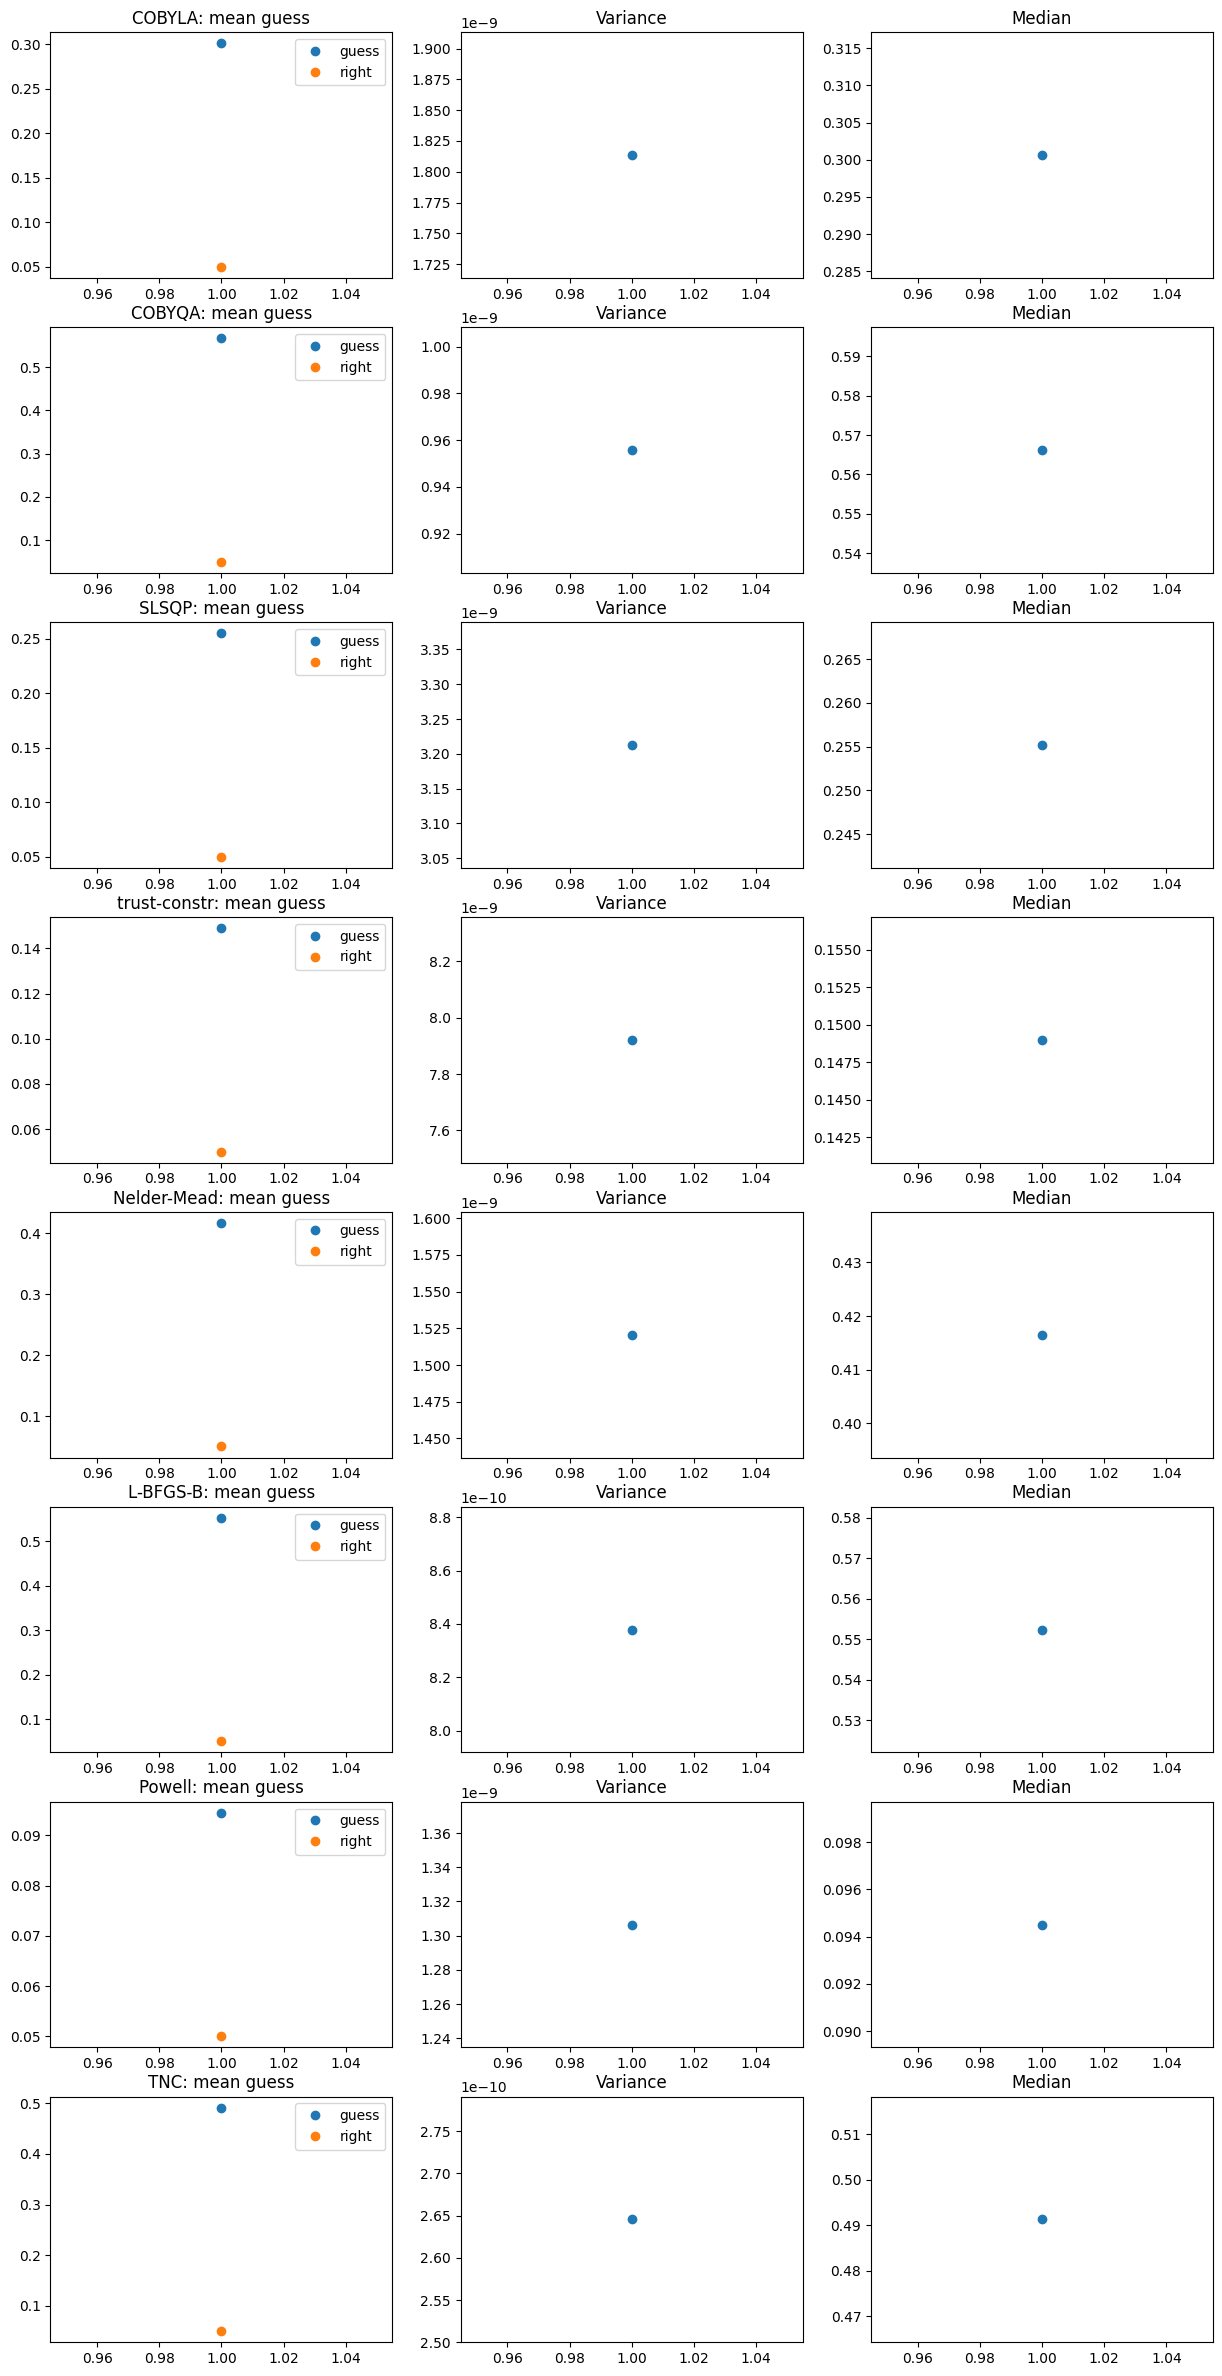

In [48]:
visualize_absolute(res1_1_1,
                   algorithms=methods,
                   save=True,
                   idea=1,
                   mean_func_num=1,
                   single_func_num=1,
                   version=1
)

In [ ]:
visualize_error(res1_1_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=1, mean_func_num=1, single_func_num=1, version=1)

### d1.1 + f1.2

In [239]:
res1_1_2 = get_accuracy_test_results(mean_distribution1_2, single_distr1_1)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

In [ ]:
visualize_absolute(res1_1_2, save=True, idea=1, mean_func_num=2, single_func_num=1, version=1)

In [ ]:
visualize_error(res1_1_2, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=1, mean_func_num=2, single_func_num=1, version=1)

### d1.2 + f1.1

In [242]:
res1_2_1 = get_accuracy_test_results(mean_distribution1_1, single_distr1_2)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

In [ ]:
visualize_absolute(res1_2_1, save=True, idea=1, mean_func_num=1, single_func_num=2, version=1)

In [ ]:
visualize_error(res1_2_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=1, mean_func_num=1, single_func_num=2, version=1)

### d1.2 + f1.2

In [245]:
res1_2_2 = get_accuracy_test_results(mean_distribution1_2, single_distr1_2)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

In [ ]:
visualize_absolute(res1_2_2, save=True, idea=1, mean_func_num=2, single_func_num=2, version=1)

In [ ]:
visualize_error(res1_2_2, np.array([0.1, 0.05, 0.02, 0.01]))

### d1.3 + f1.1

In [261]:
res1_3_1 = get_accuracy_test_results(mean_distribution1_1, single_distr1_3)

In [ ]:
visualize_absolute(res1_3_1, save=True, mean_func_num=1, single_func_num=3)

In [ ]:
visualize_error(res1_3_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, mean_func_num=1, single_func_num=3)

### d1.3 + f1.2

In [264]:
res1_3_2 = get_accuracy_test_results(mean_distribution1_2, single_distr1_3)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

In [ ]:
visualize_absolute(res1_3_2, save=True, mean_func_num=2, single_func_num=3)

In [ ]:
visualize_error(res1_3_2, np.array([0.1, 0.05, 0.02, 0.01]), save=True, mean_func_num=2, single_func_num=3)

### d1.4 + f1.1

In [269]:
res1_4_1 = get_accuracy_test_results(mean_distribution1_1, single_distr1_4)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

In [ ]:
visualize_absolute(res1_4_1, save=True, idea=1, single_func_num=4, mean_func_num=1, version=1)

In [ ]:
visualize_error(res1_4_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=1, single_func_num=4, mean_func_num=1)

### d1.4 + f1.2

In [272]:
res1_4_2 = get_accuracy_test_results(mean_distribution1_2, single_distr1_4)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

In [ ]:
visualize_absolute(res1_4_2, save=True, idea=1, single_func_num=4, mean_func_num=2, version=1)

In [ ]:
visualize_error(res1_4_2, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=1, single_func_num=4, mean_func_num=2, version=1)

### d1.5 + f1.1

In [275]:
res1_5_1 = get_accuracy_test_results(mean_distribution1_1, single_distr1_5)

In [ ]:
visualize_absolute(res1_5_1, save=True, idea=1, single_func_num=5, mean_func_num=1, version=1)

In [ ]:
visualize_error(res1_5_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=1, single_func_num=5, mean_func_num=1, version=1)

## Выводы?

- d1 + f2 вообще фигня нерабочая
- d3 ожидаемо бредовый

# Идея 2: векторы длины от макс. возможного числа соседей из **референсов** на ветке ($\le 4k_r$) (TODO выводы)

Здесь $|H| = i$

Получается, что длина вектора $4k_r$, и нумерацию начинать надо с $1$, т.к. у любого экземпляра будет хотя бы один сосед.

## Распределение для одного экземпляра

### d2.1. Чистая длина участков

Назовём распределением $d_{el}$ для одного экземпляра el вектор, такой что

$ \displaystyle d_{el} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}} L^t$ 

In [199]:
def single_distr2_1(treeseq, reference, sample):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_reference*4)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        vector[nearest.size - 1] += tree.span
    vector /= subts.sequence_length
    return vector

### d2.2. Взвешиваем по числу соседей из A

Назовём распределением $d_{el}$ для одного экземпляра el вектор, такой что

$ \displaystyle d_{el} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}} L^t |H \cap ref_A|$ 

In [200]:
def single_distr2_2(treeseq, reference, sample):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_reference*4)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < 2 * k_reference].size
        vector[nearest.size - 1] += tree.span * refA_neighbours
    vector /= subts.sequence_length
    return vector

## Распределение популяции

### f2.1 = f1.1

In [18]:
def mean_distribution2_1(treeseq, reference, samples, single_func):
    """
    Calculate population distribution function as mean of distributions of samples
    """
    vector = np.zeros(k_reference*4)
    for el in samples:
        vector += single_func(treeseq, reference, el)
    vector /= len(samples)
    return vector

### f2.2. Еще делим i-ю ячейку на i

$\displaystyle f_P = \frac{1}{|P|} a^T \odot \sum_{el \in P} d(el) $

где $a^T = [1, \frac{1}{2}, ..., \frac{1}{4k_r}] \in \mathbb{N}^{4k_r + 1}, \odot$ - адамарово произведение

In [17]:
def mean_distribution2_2(treeseq, reference, samples, single_func):
    vector = np.zeros(k_reference*4)
    for el in samples:
        vector += single_func(treeseq, reference, el)
    vector /= len(samples)
    vector /= np.arange(1, 4 * k_reference + 1)
    return vector

## Тестируем

### d2.1 + f2.1

In [201]:
res2_1_1 = get_accuracy_test_results(mean_distribution2_1, single_distr2_1)

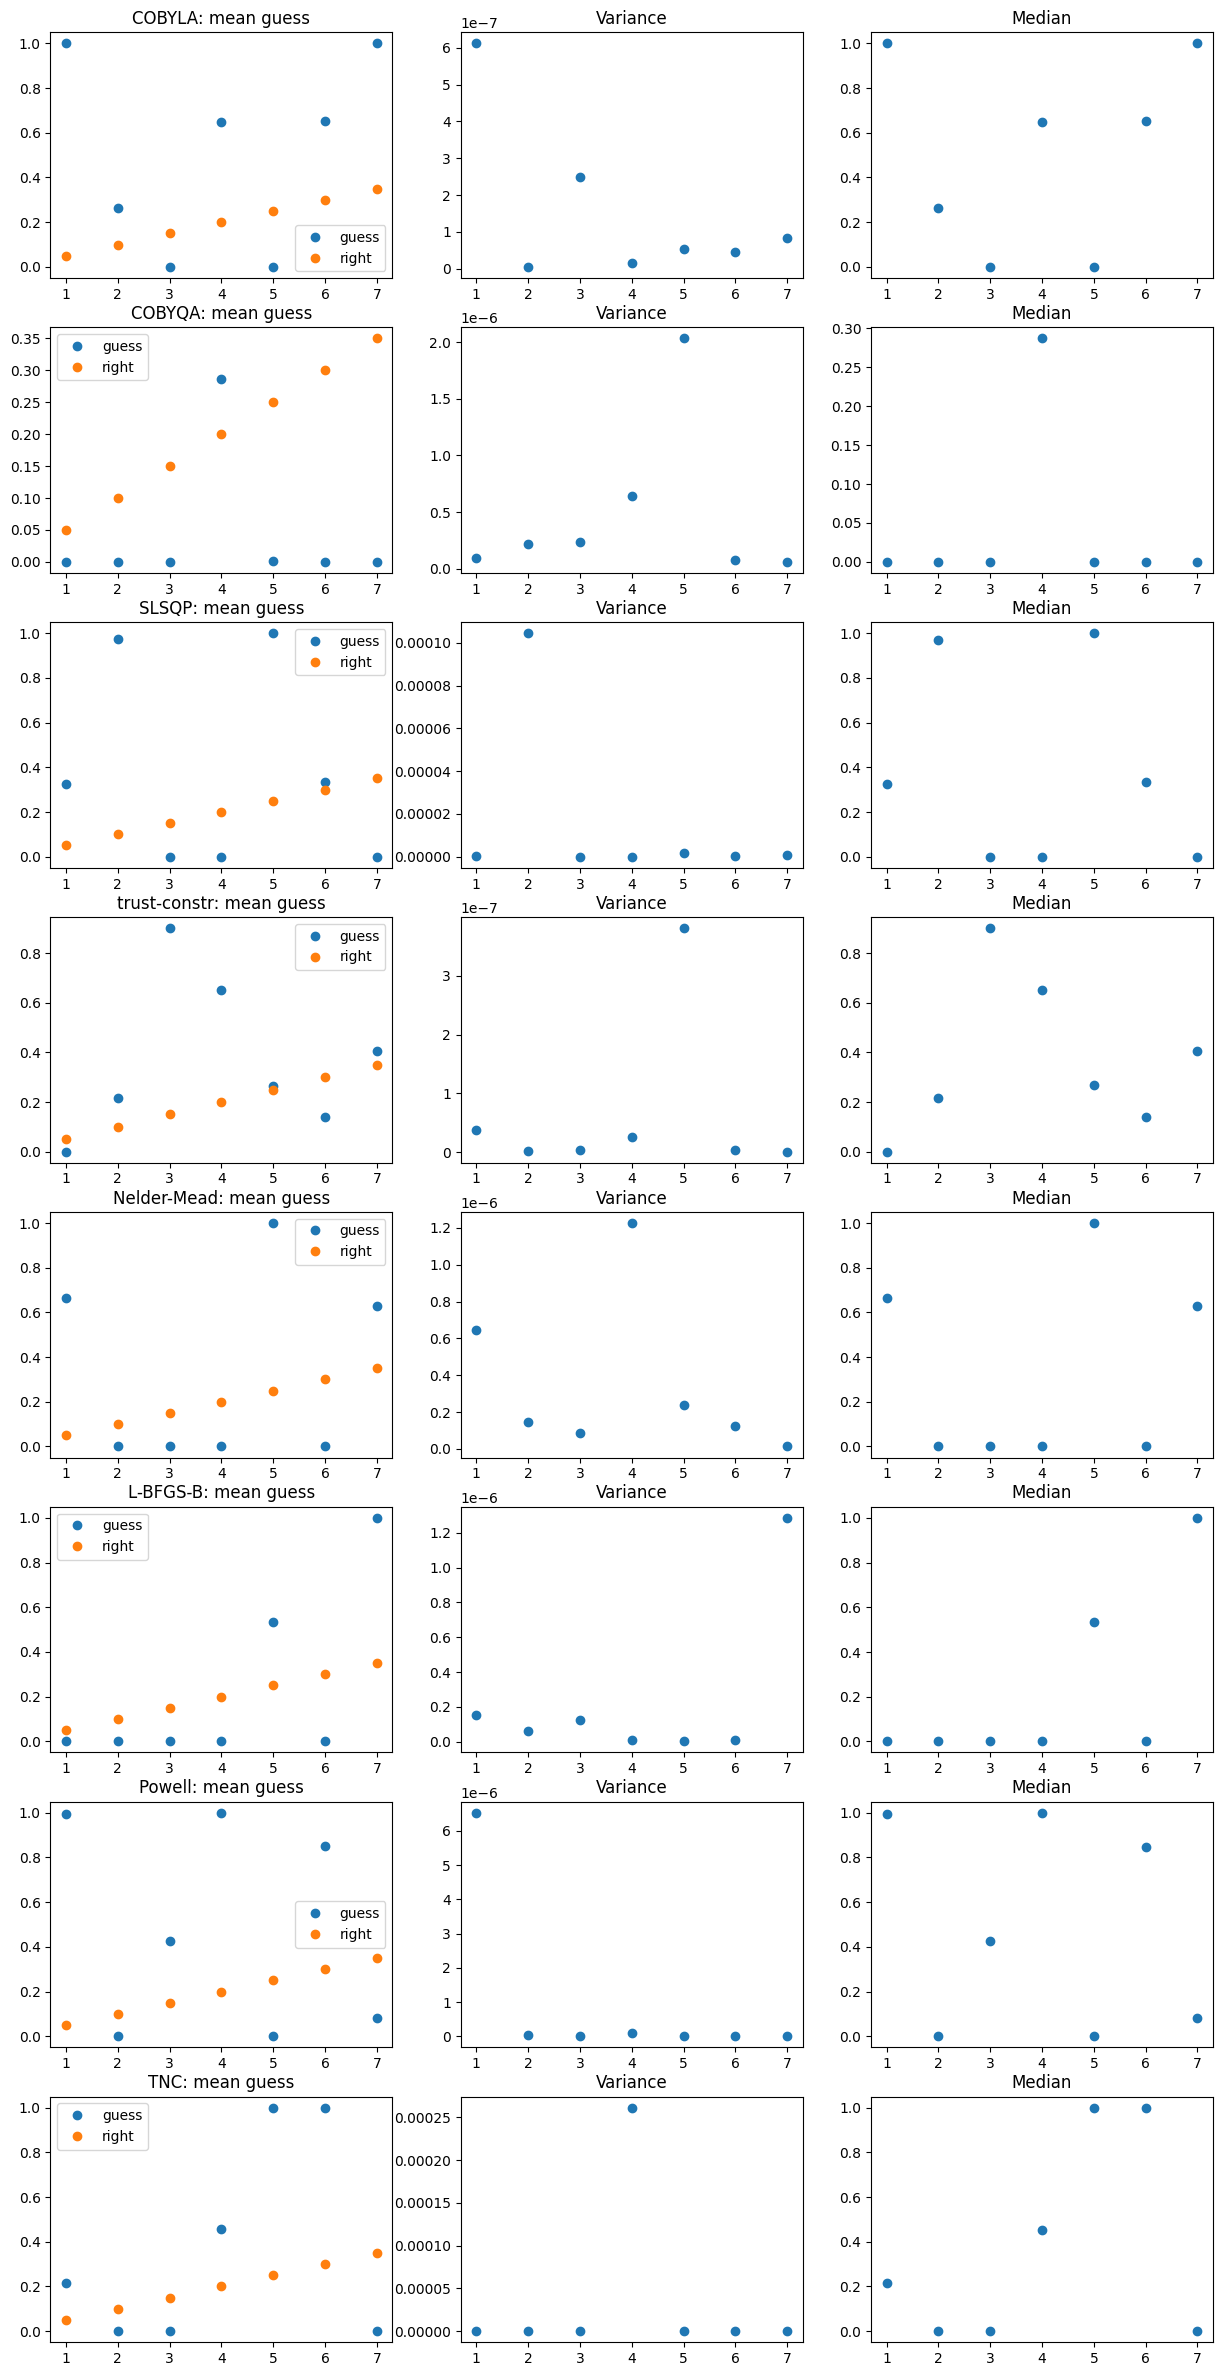

In [345]:
visualize_absolute(res2_1_1, save=True, idea=2, mean_func_num=1, single_func_num=1, version=1)

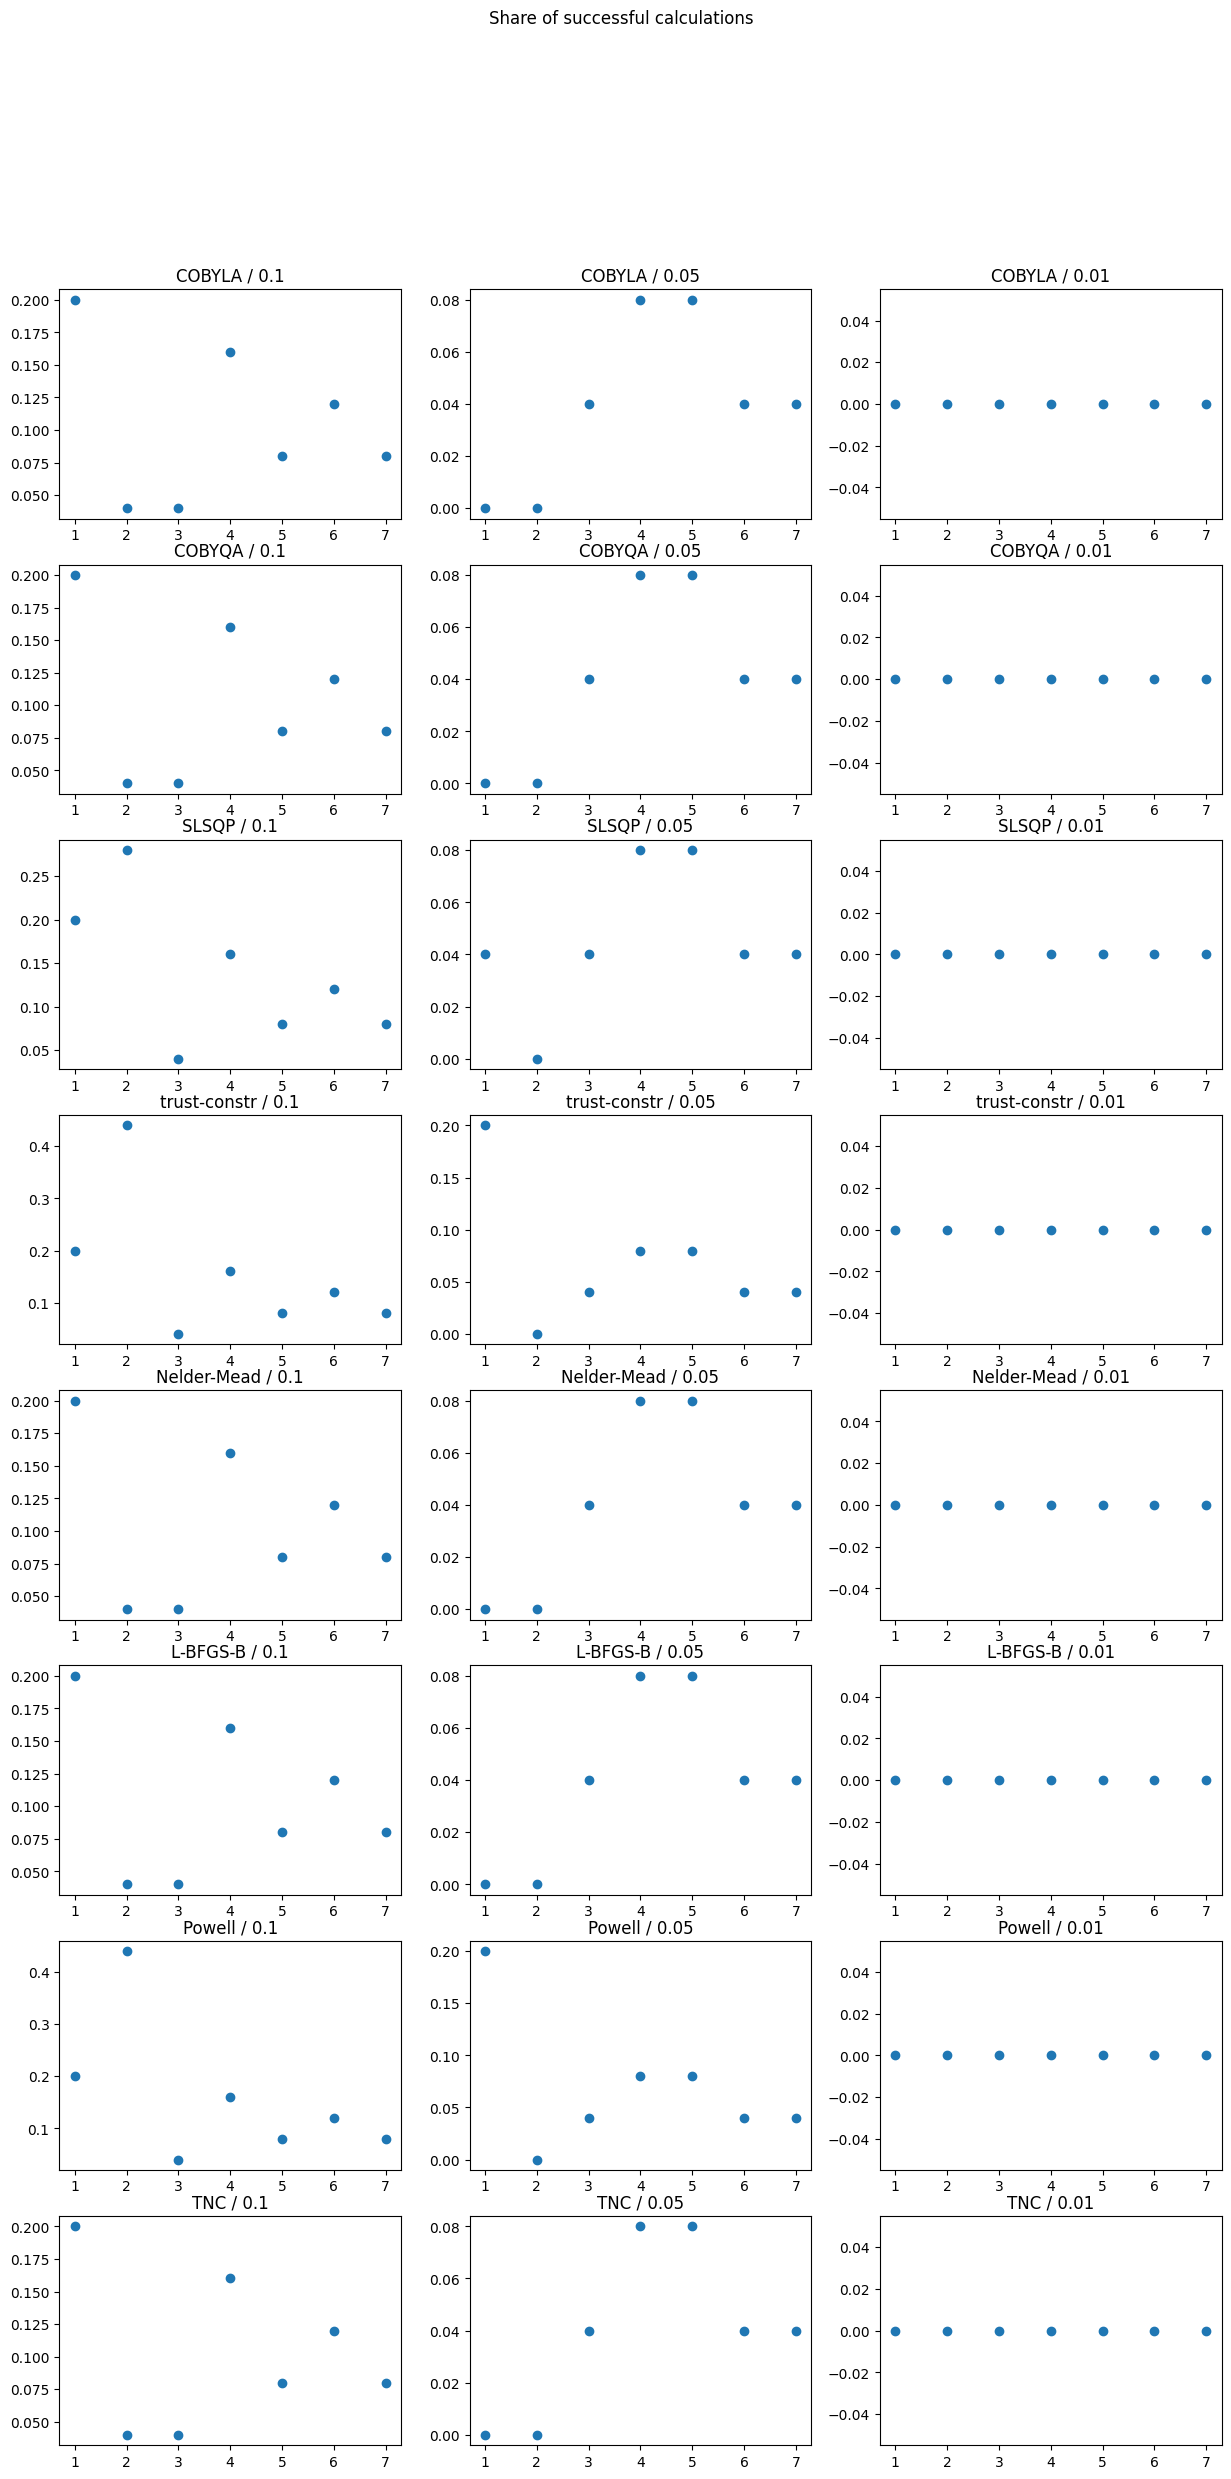

In [346]:
visualize_error(res2_1_1, np.array([0.1, 0.05, 0.01]), save=True, idea=2, mean_func_num=1, single_func_num=1, version=1)

### d2.1 + f2.2

In [347]:
res2_1_2 = get_accuracy_test_results(mean_distribution2_2, single_distr2_1)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

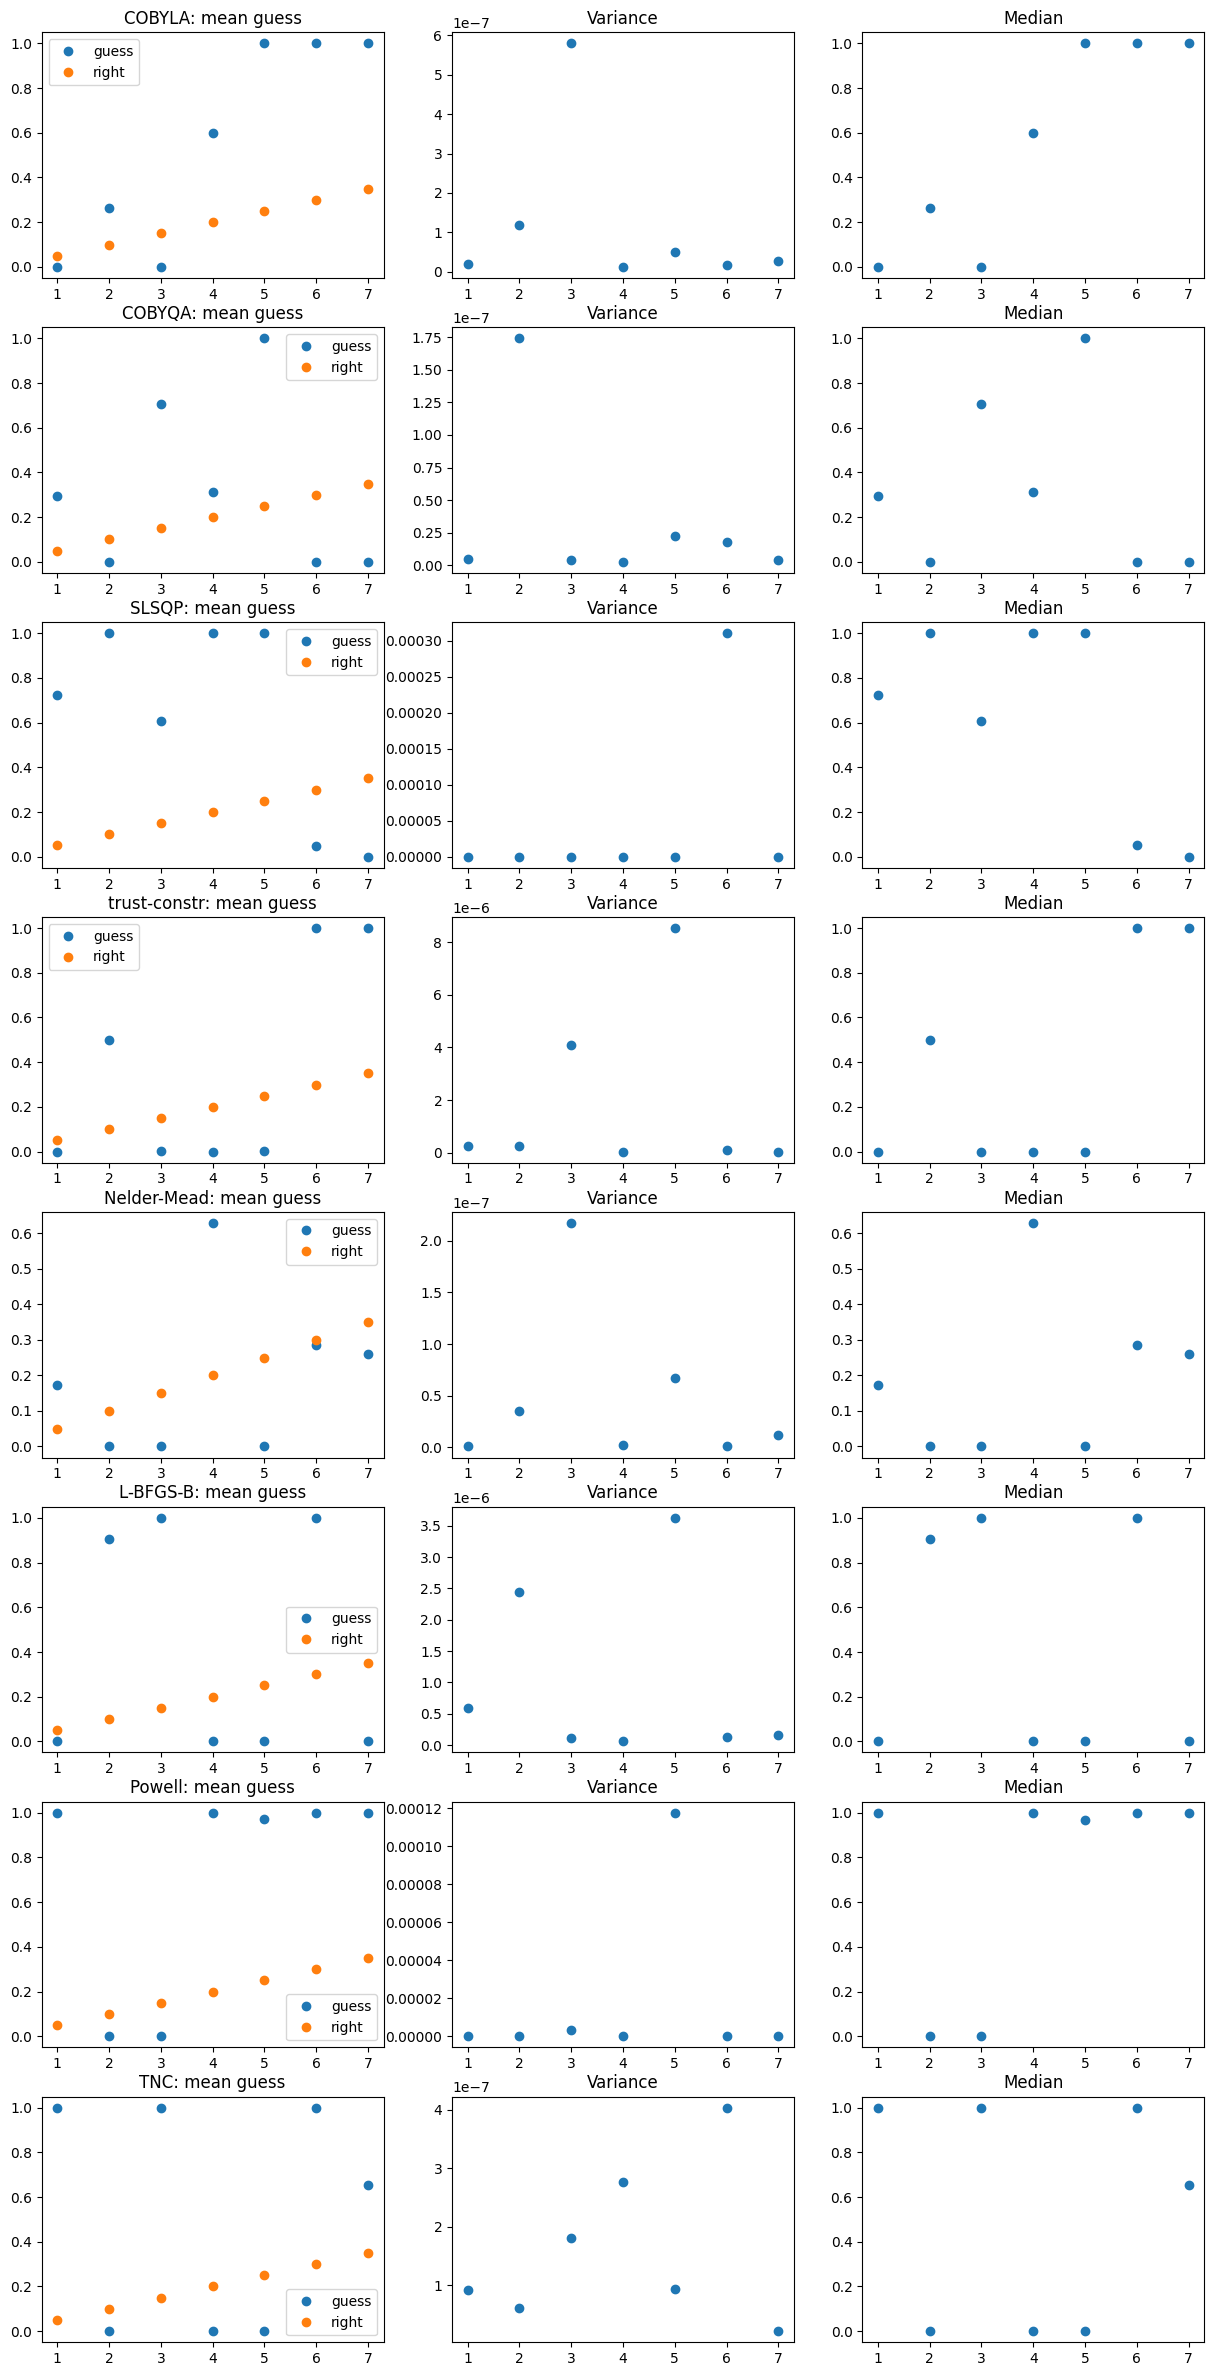

In [348]:
visualize_absolute(res2_1_2, save=True, idea=2, mean_func_num=2, single_func_num=1, version=1)

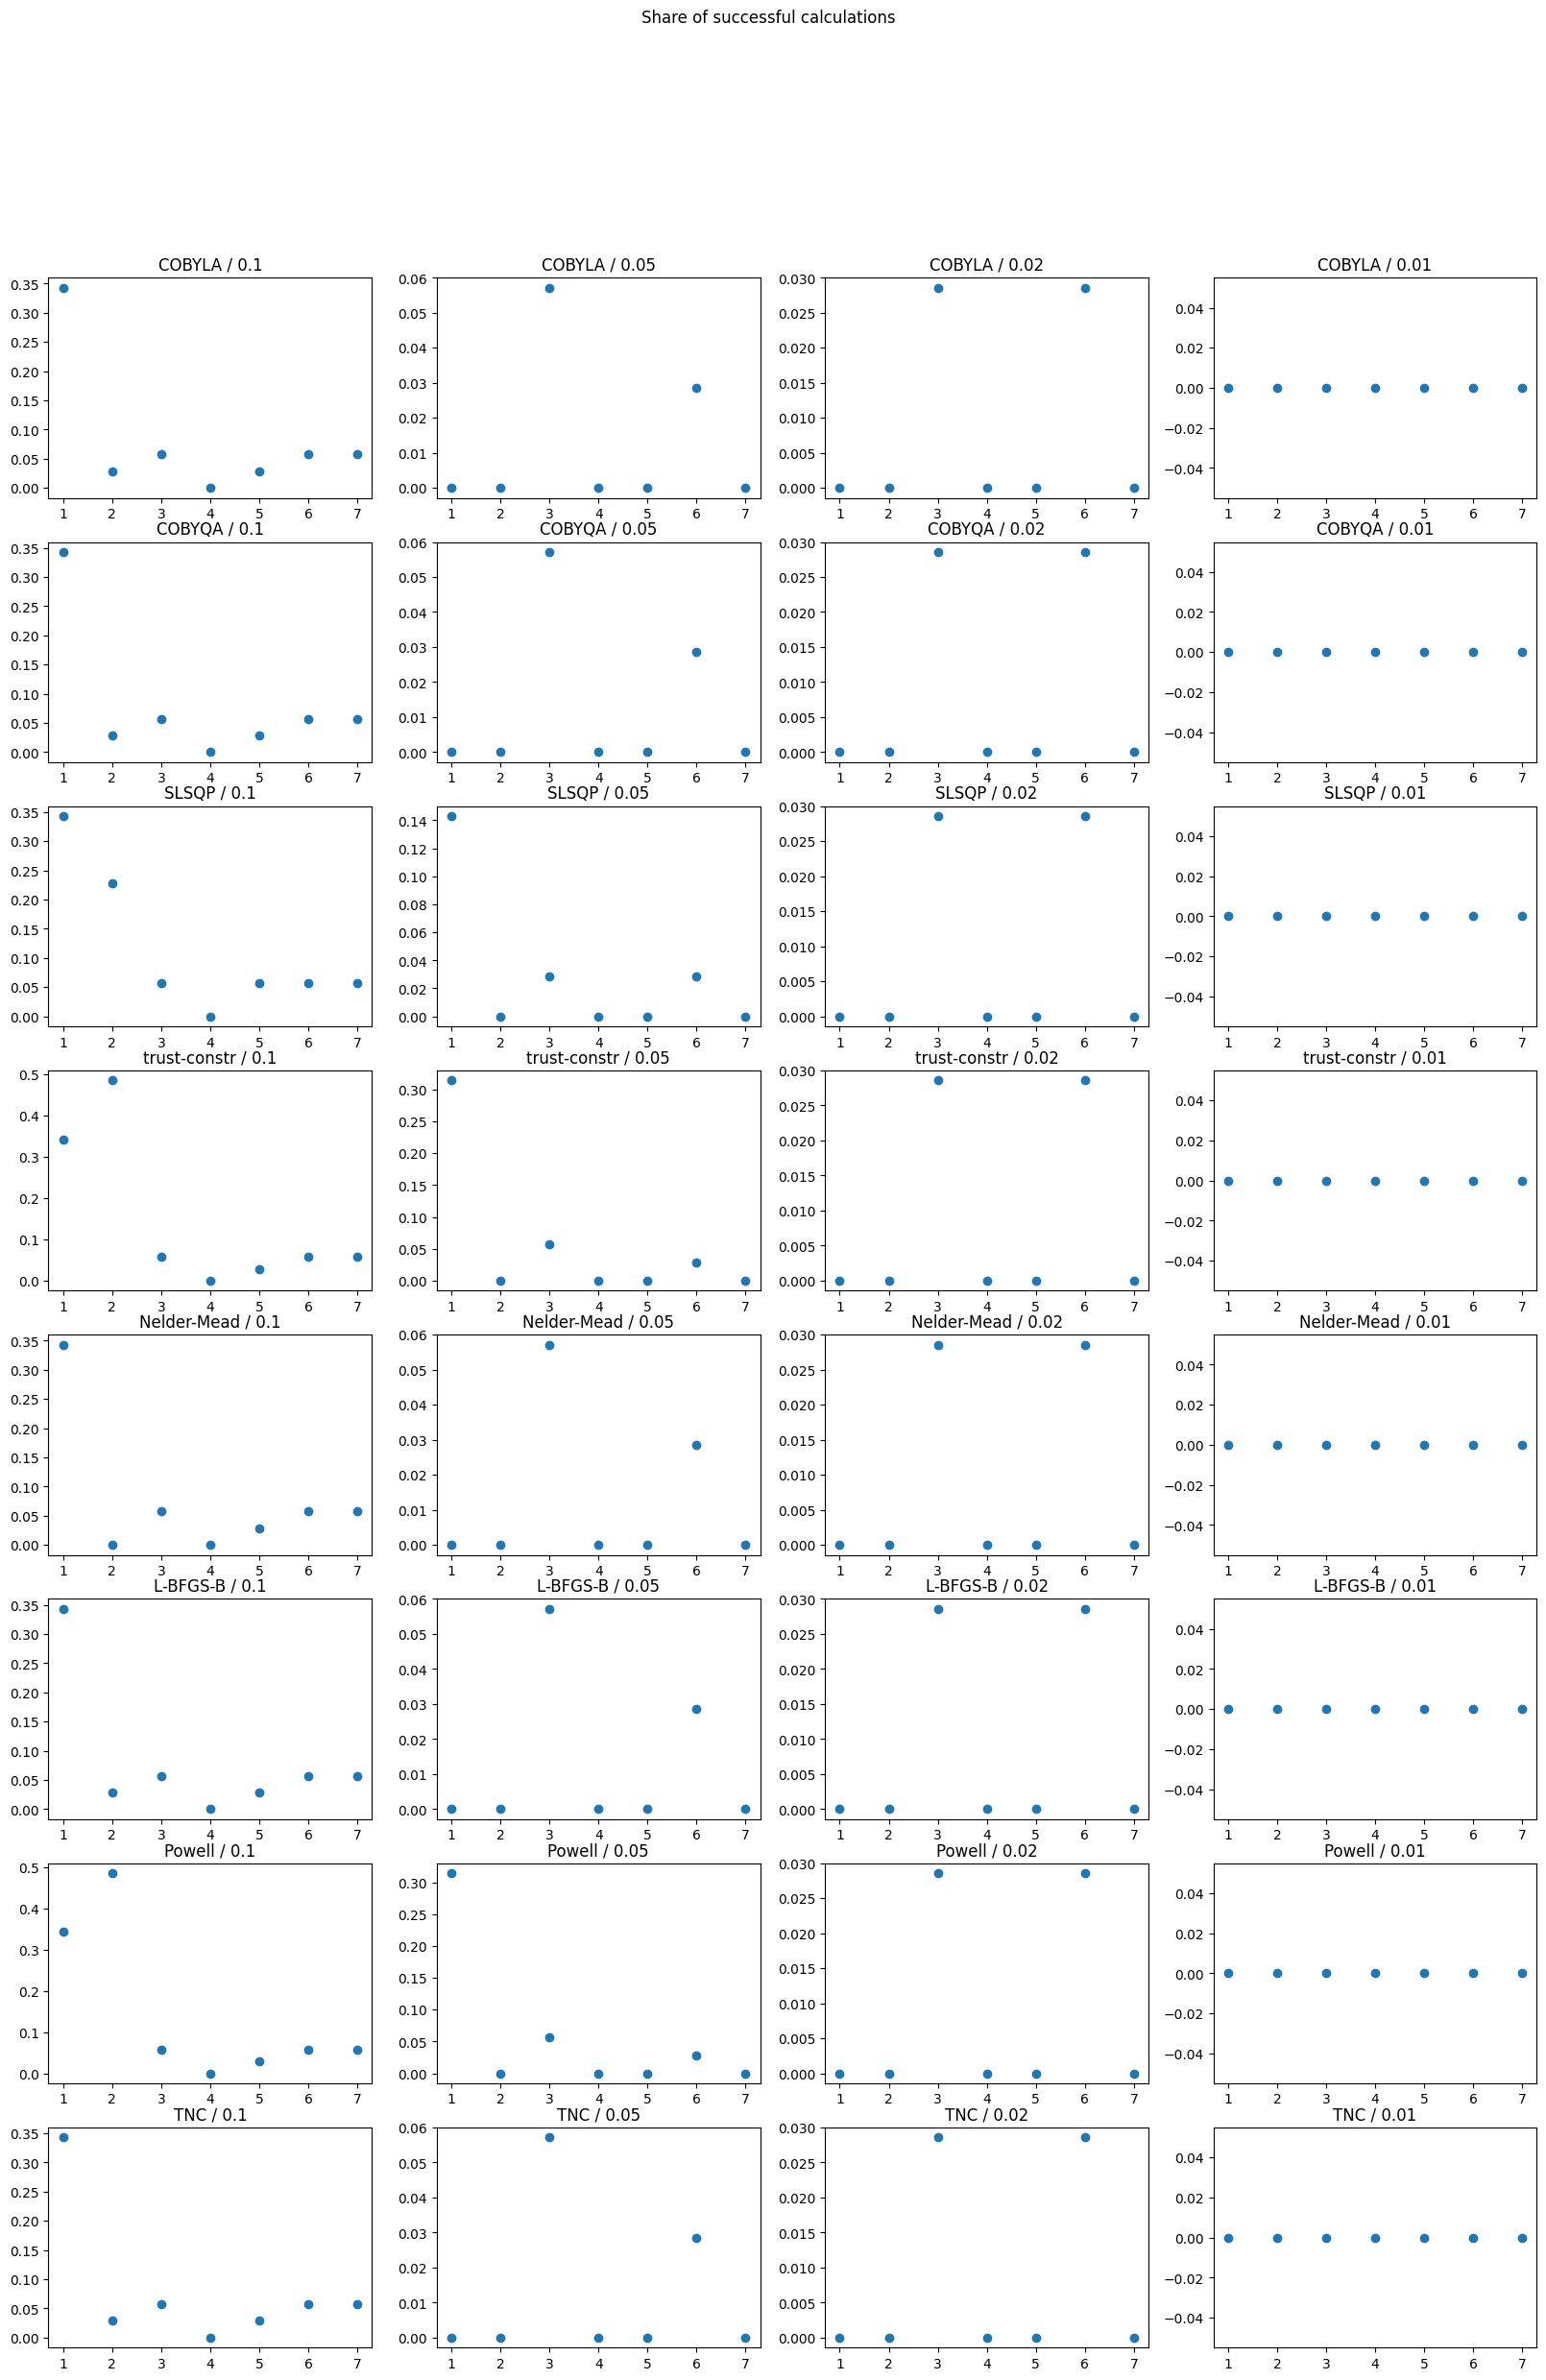

In [349]:
visualize_error(res2_1_2, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=2, mean_func_num=2, single_func_num=1, version=1)

### d2.2 + f2.1

In [350]:
res2_2_1 = get_accuracy_test_results(mean_distribution2_1, single_distr2_2)

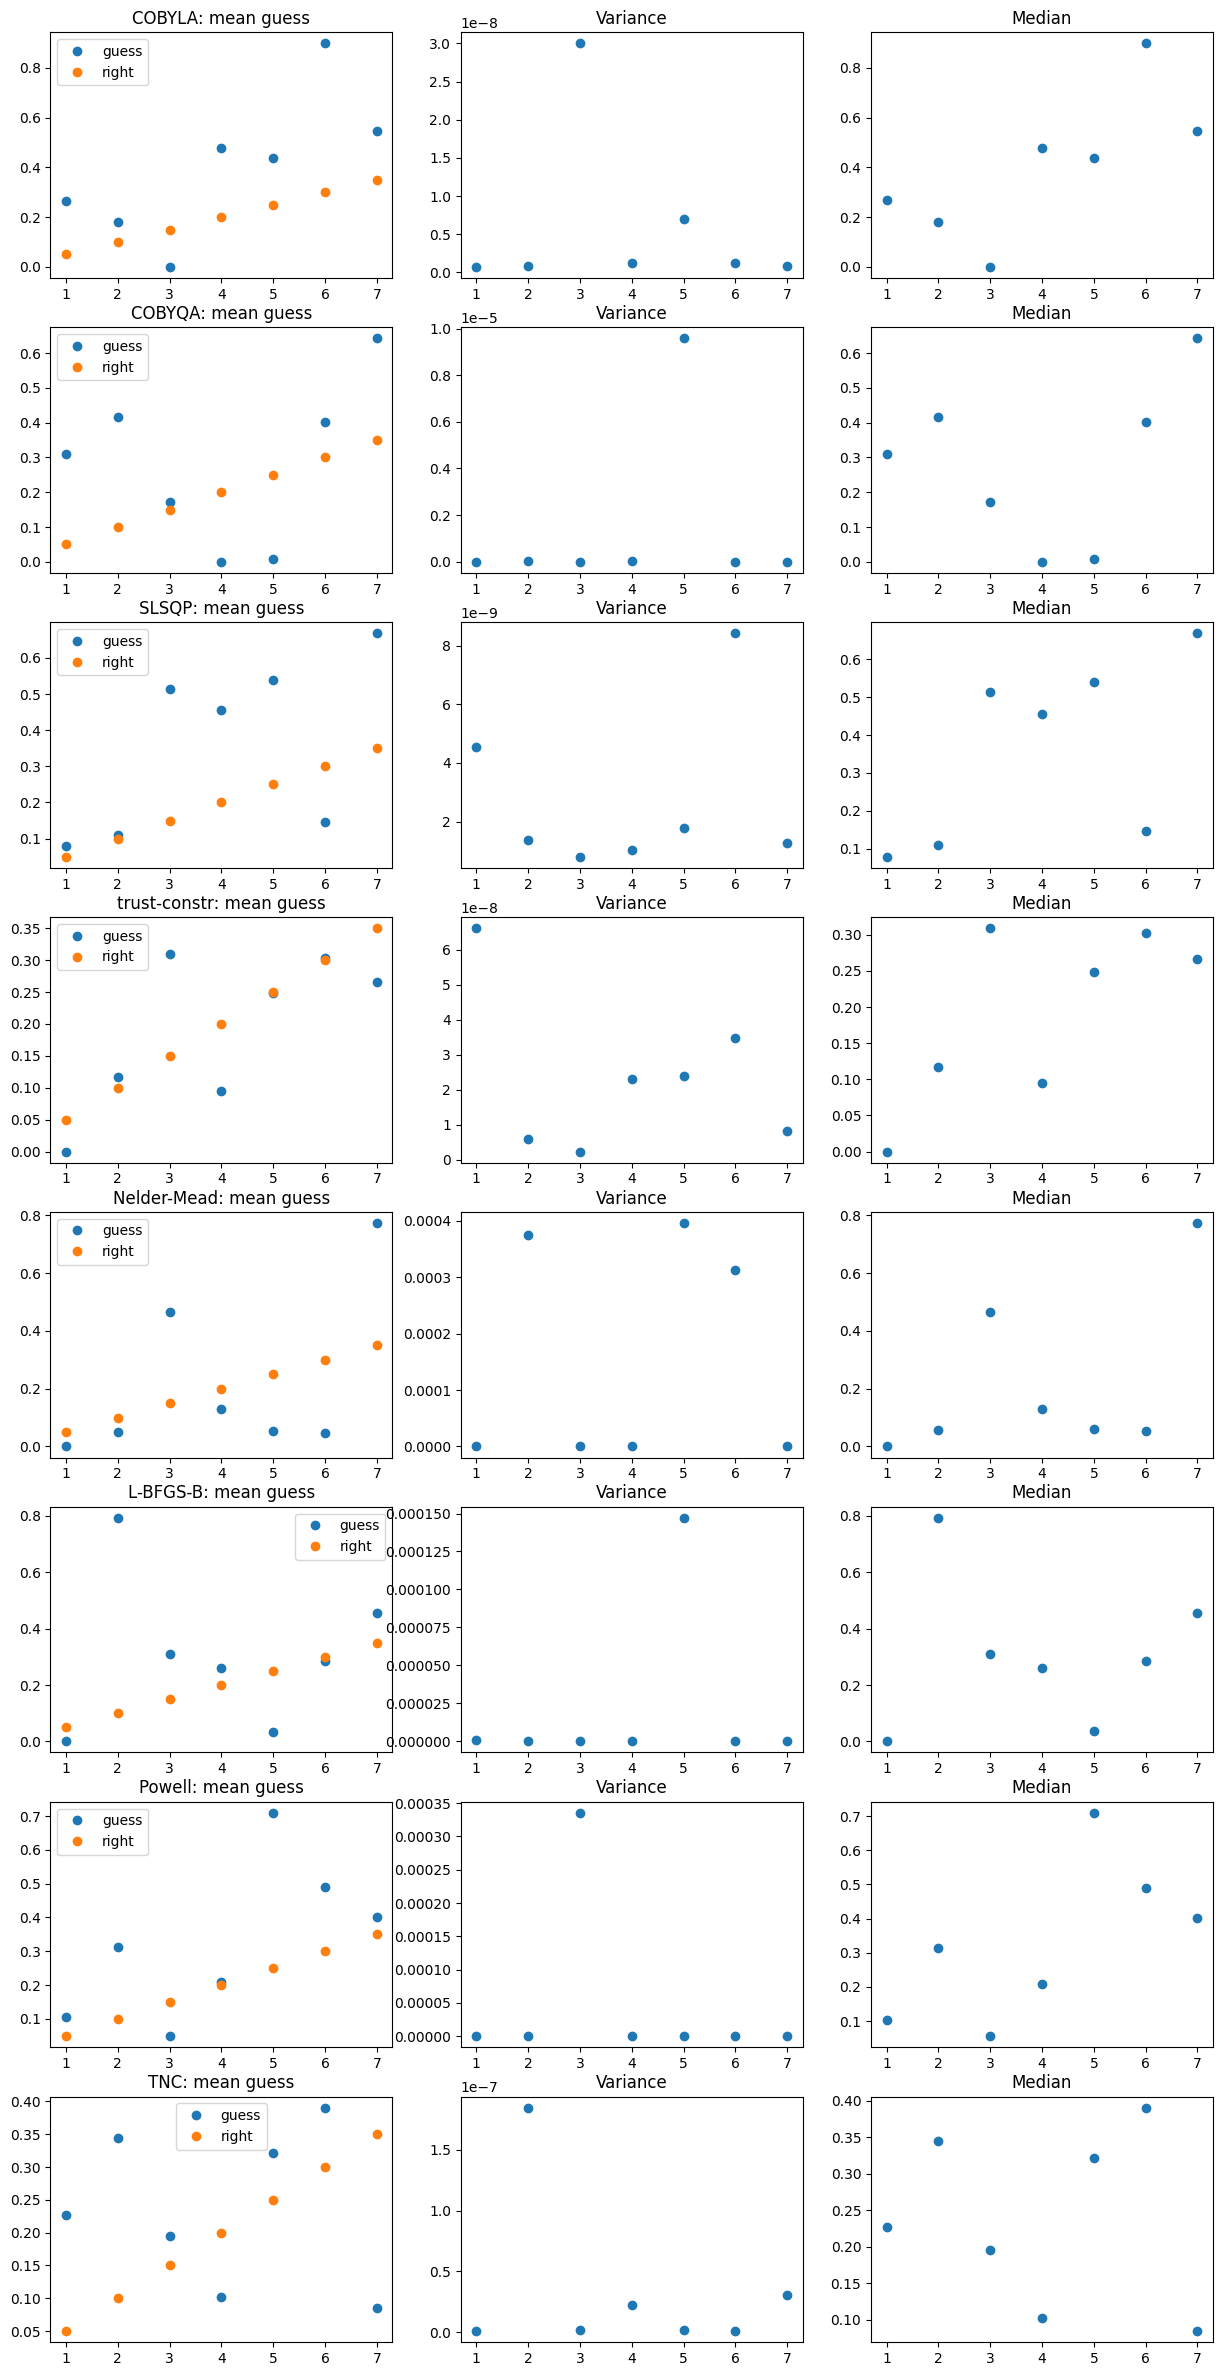

In [351]:
visualize_absolute(res2_2_1, save=True, idea=2, mean_func_num=1, single_func_num=2, version=1)

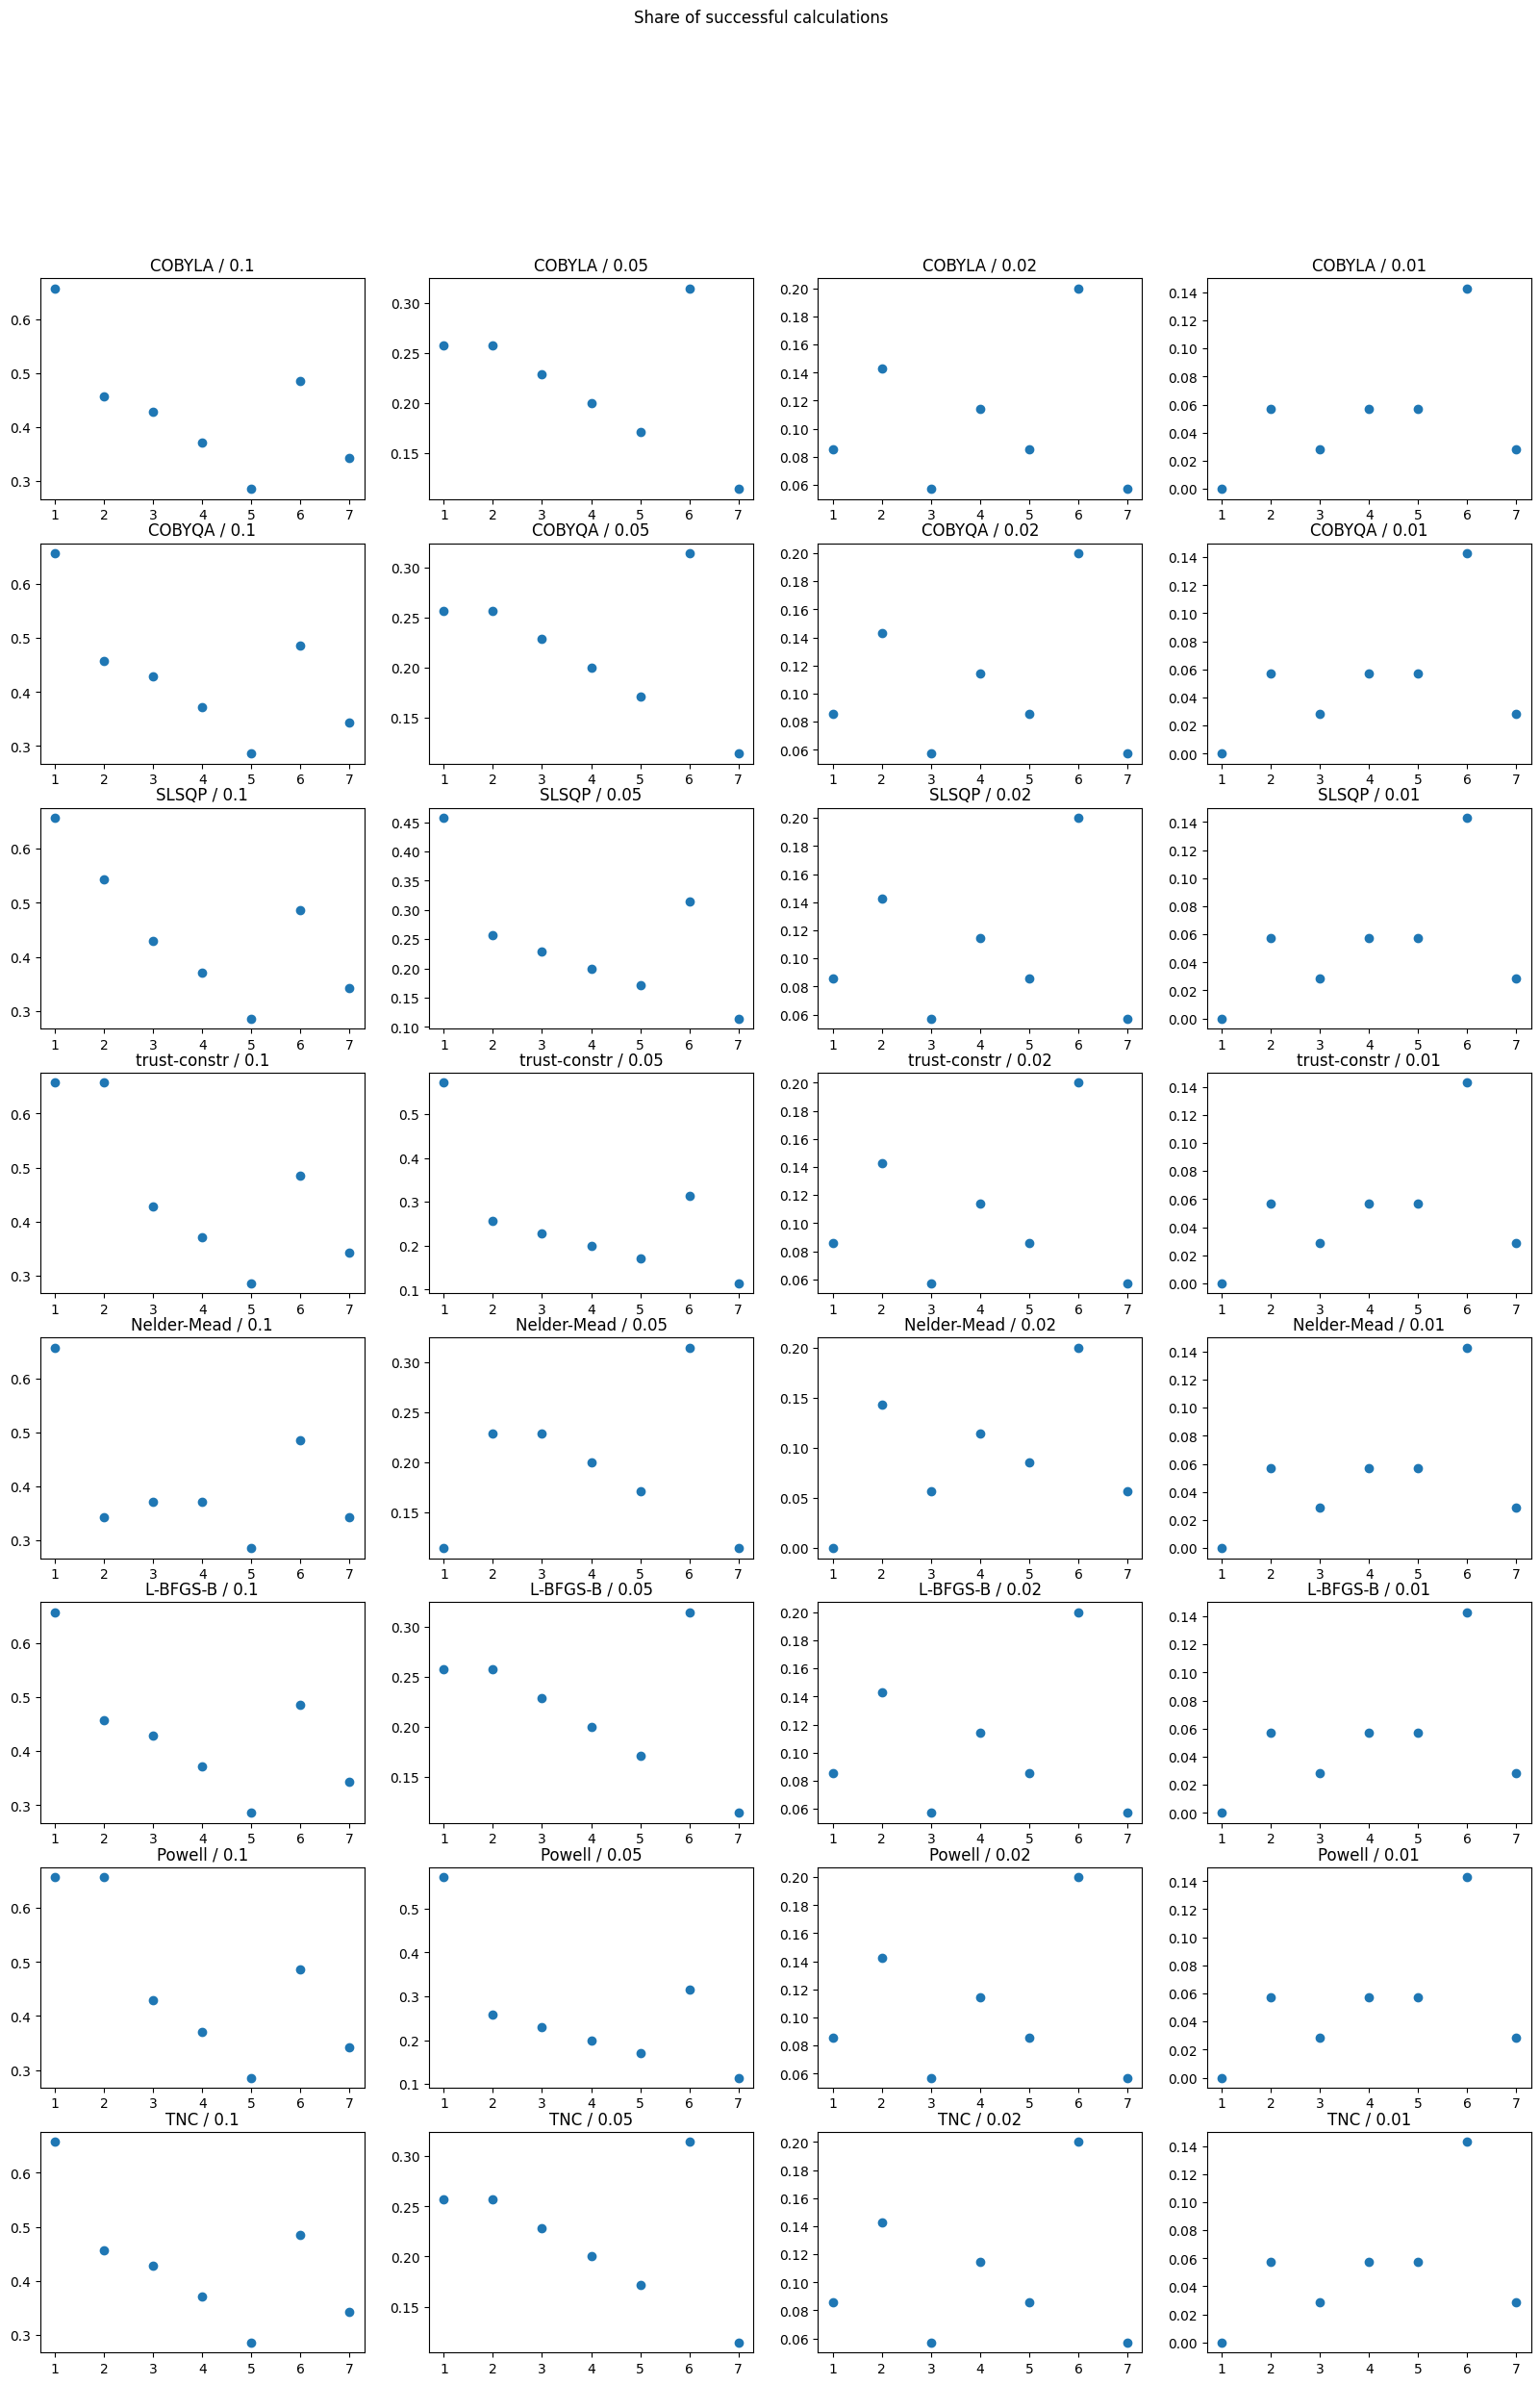

In [352]:
visualize_error(res2_2_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=2, mean_func_num=1, single_func_num=2, version=1)

### d2.2 + f2.2

In [66]:
res2_2_2 = get_accuracy_test_results(mean_distribution2_2, single_distr2_2)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


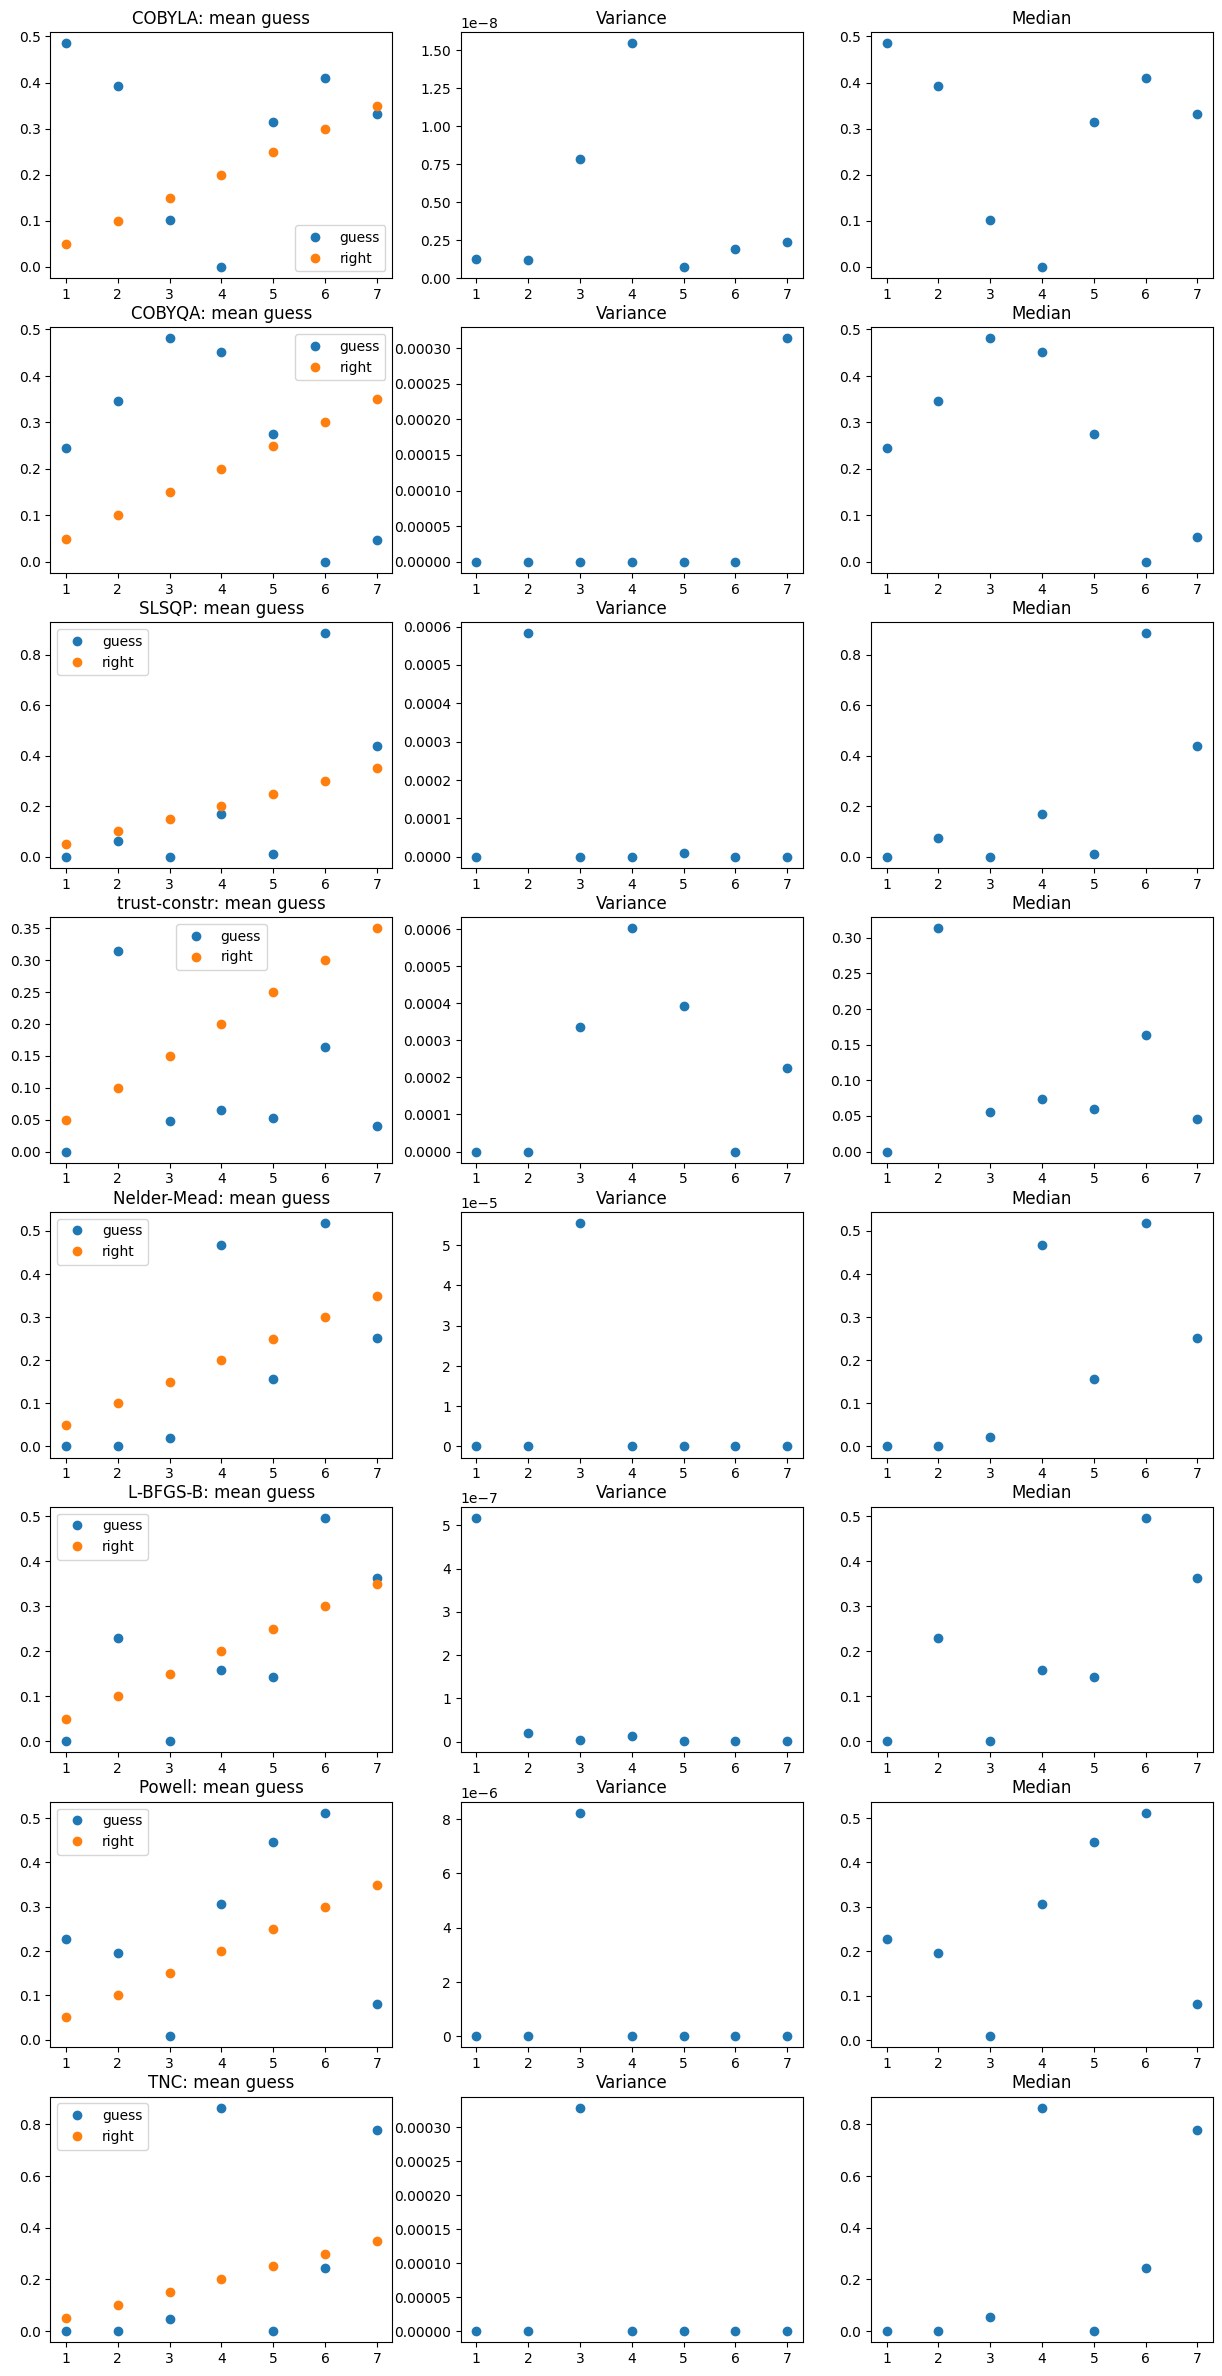

In [426]:
visualize_absolute(res2_2_2, save=True, idea=2, mean_func_num=2, single_func_num=2, version=1)

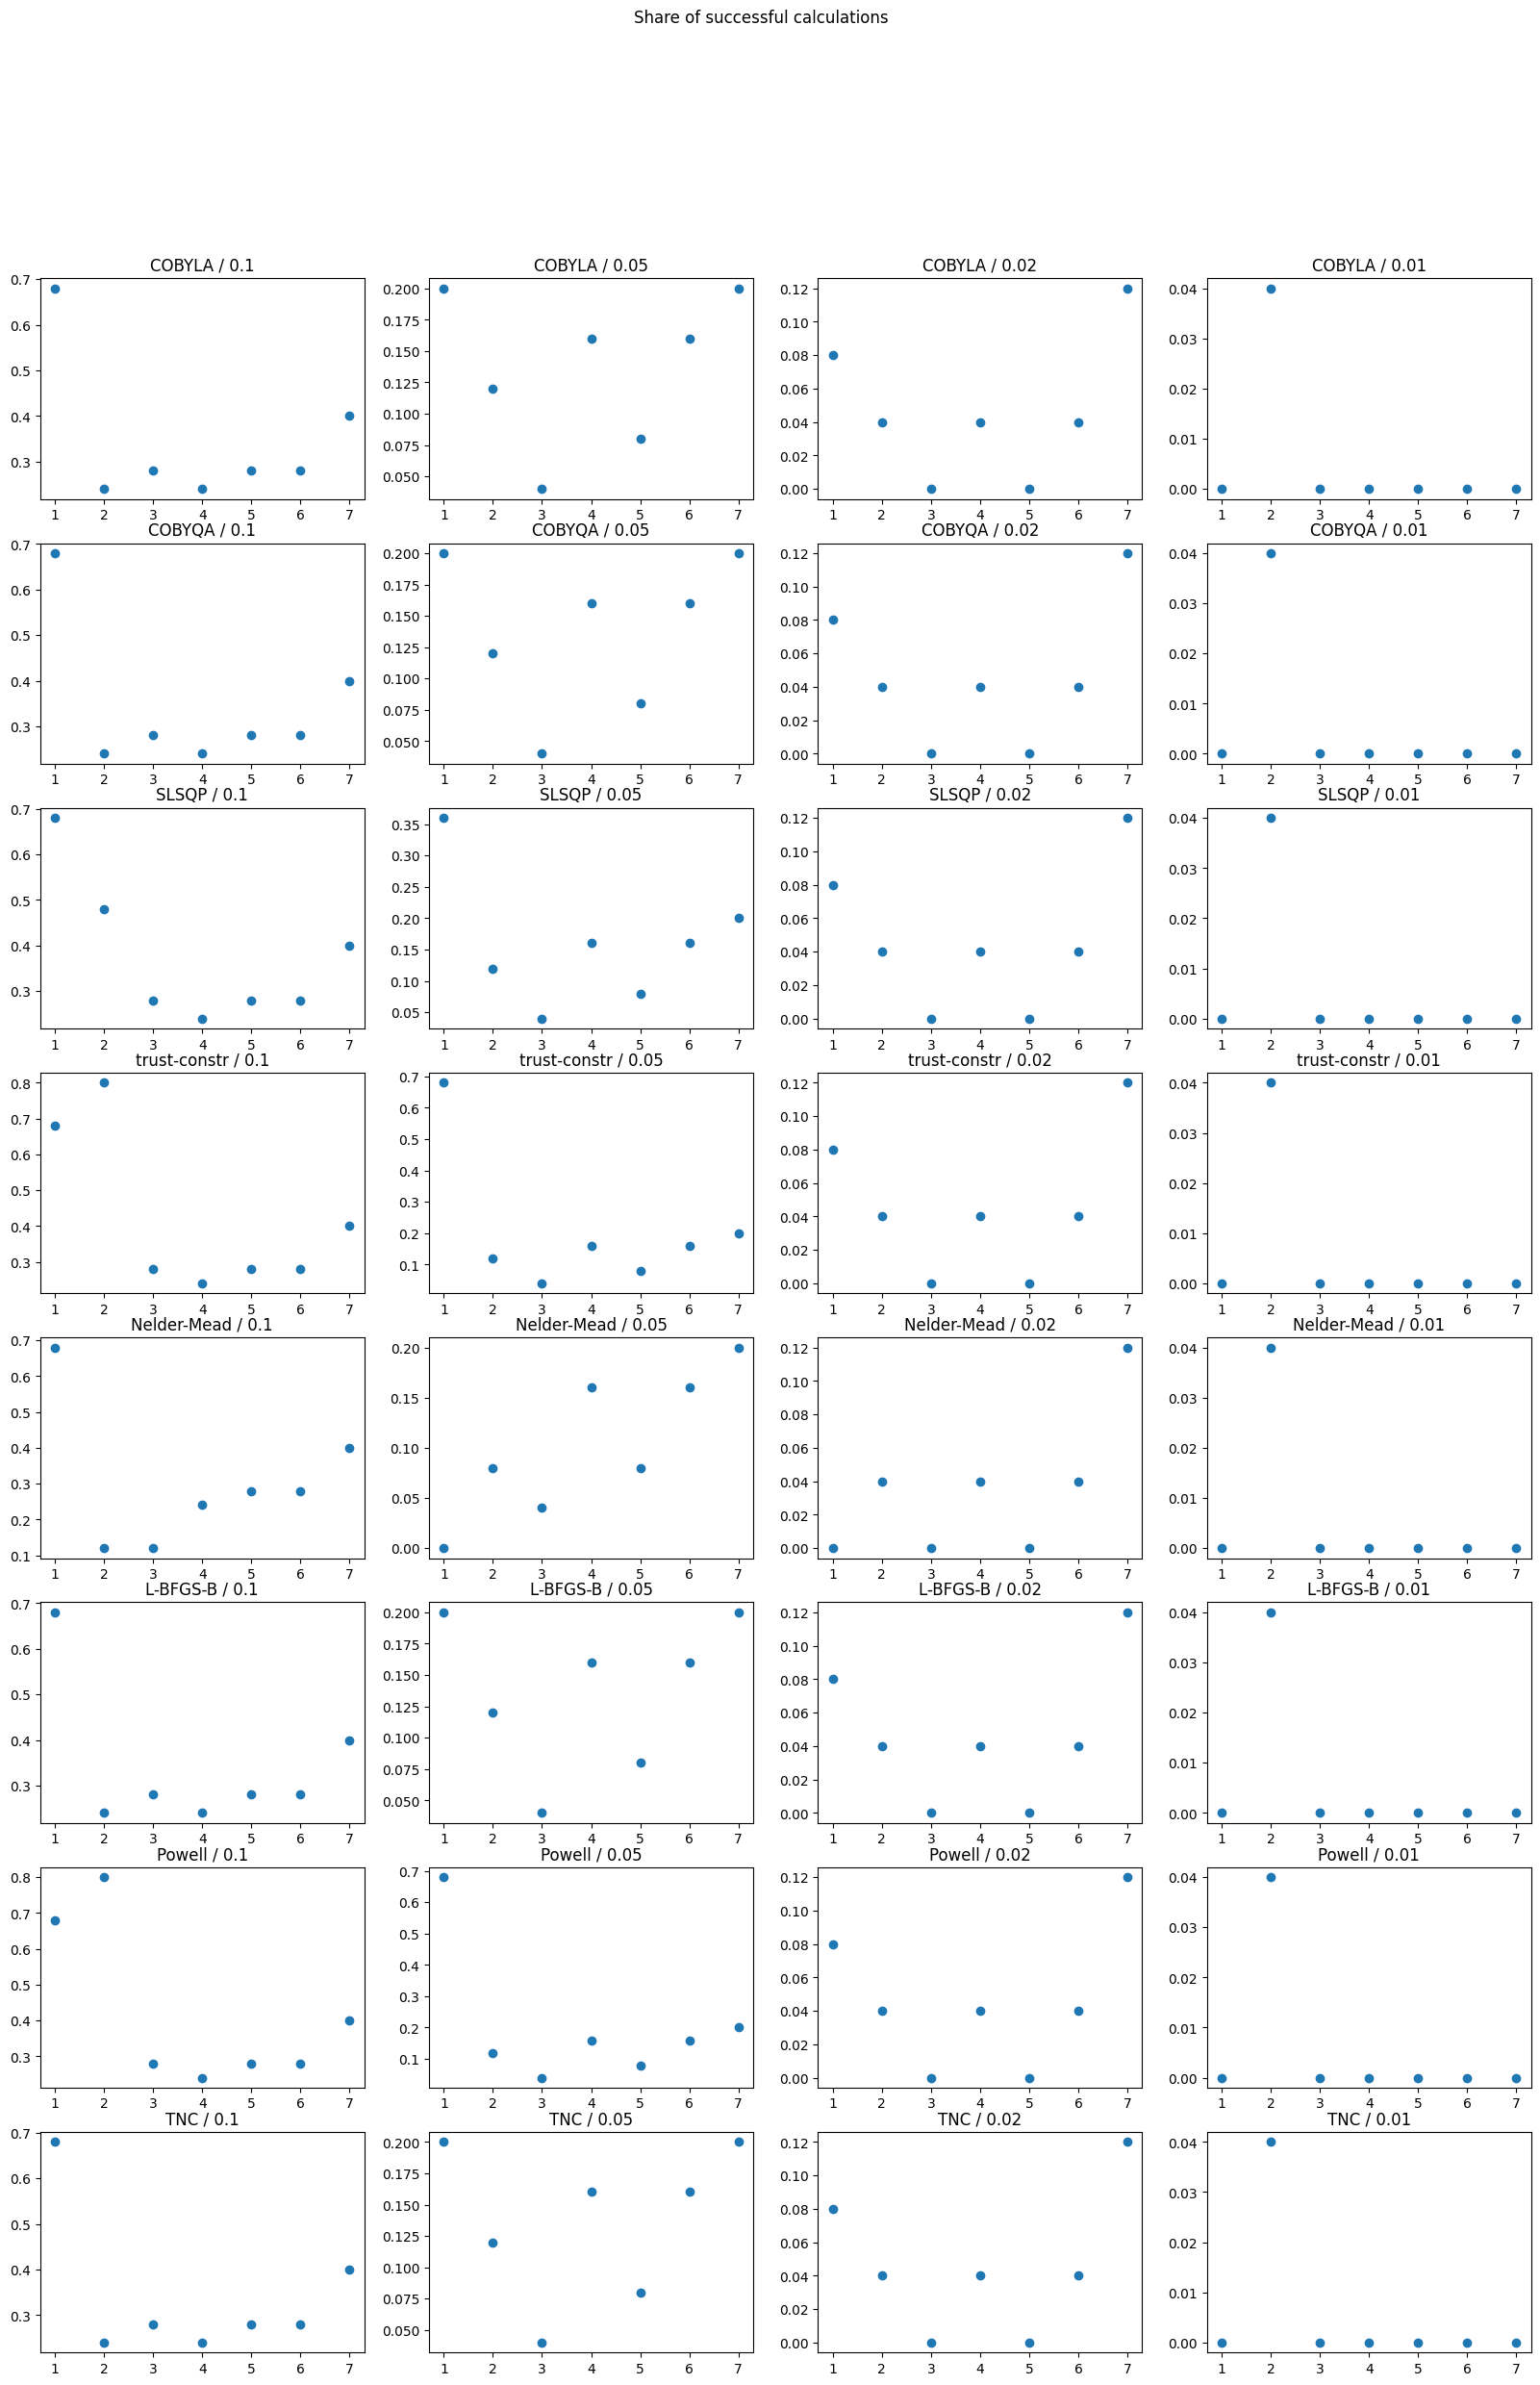

In [427]:
visualize_error(res2_2_2, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=2, mean_func_num=2, single_func_num=2, version=1)

## Выводы?

# Идея 3: Возвращение к оценке без учета длины ветки.

Флешбек на последнюю учебную [подготовительную] задачу. У нас не фигурировали референсы, обучающие и валидационные выборки, просто были популяции A, B, C, и надо было определить коэффициент $\alpha$ смеси $C$. По доказанному соображению нам было известно

$\displaystyle l_C = \alpha \cdot l_A + (1-\alpha) \cdot l_B$

Отсюда

$\alpha = \frac{l_C-l_B}{l_A-l_B}$

$l_P$ это "распределение популяции". В тот раз мне показалось [на глаз, без существующий сейчас тестов] достаточно точным такое вычисление:

Для некоторого семпла $s$ назовем средневзешенным числом соседей из популяции $P$ число

$\displaystyle w_{s, P} = \frac{1}{L} \sum_{t \in \mathbb{T}} |H \cap P| \cdot L^t  $

Cредневзешенным числом соседей из популяции $P$ для популяции $Q$ назовем

$\displaystyle W_{Q, P} = \frac{1}{|Q|} \sum_{s \in Q} w_{s, P}  $

Тогда **статистики распределения соседей** [=доля соседей из A] для P = A, B, C насчитываются как 

$l_{P} = \frac{ W_{A, P}}{(W_{A, P} + W_{B, P})}$

Сейчас мы попробуем применить эту идею, для формулы подсчета $w_{s, P}$ приняв $P = ref_P$ для нашей задачи

## Распределение для одного экземпляра

### d3.1

In [375]:
def single_distr3_1(treeseq, reference, sample):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    # 0 - для A, 1 - для B
    vector = np.zeros(2)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < 2 * k_reference].size
        refB_neighbours = nearest[(2 * k_reference <= nearest) & (nearest < 4 * k_reference)].size
        vector[0] += tree.span * refA_neighbours
        vector[1] += tree.span * refB_neighbours
    vector /= subts.sequence_length
    return vector

## Распределение для популяции

### f3.1

In [368]:
def mean_distribution3_1(treeseq, reference, samples, single_func):
    # single func должна возвращать вектор размерности 2!!
    vec = np.zeros(2)
    for el in samples:
        vec += single_func(treeseq, reference, el)
    vec /= samples.size
    return np.array([vec[0]/(vec[1] + vec[0])]) 

## Тестируем

Посчитаем сначала "сырым" способом, потом убедимся, что оптимизаторы считают ровно так же

In [405]:
raw_res3_1_1 = get_raw_test_results(mean_distribution3_1, single_distr3_1)

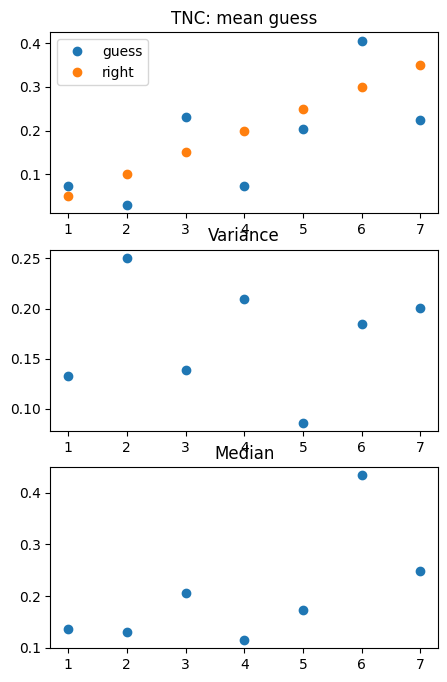

In [406]:
visualize_raw_absolute(raw_res3_1_1, save=True, idea=3, mean_func_num=1, single_func_num=1, version=1)

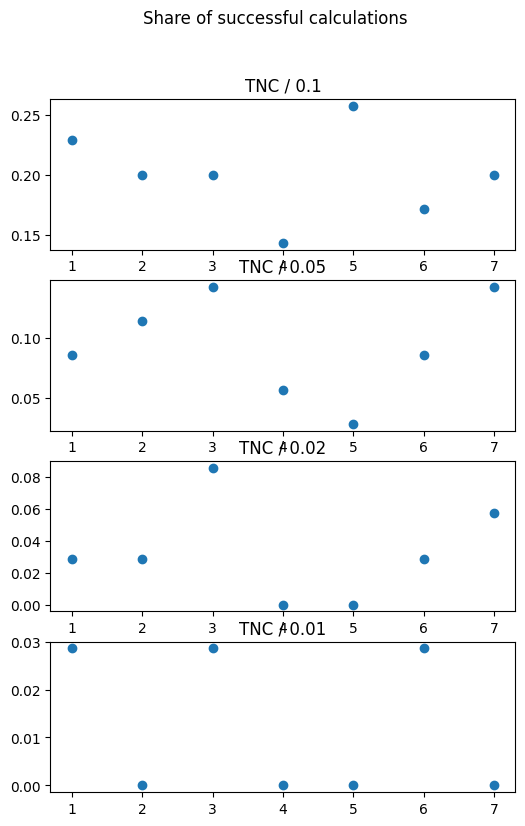

In [420]:
visualize_raw_error(raw_res3_1_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=3, mean_func_num=1, single_func_num=1, version=1)

In [422]:
res3_1_1 = get_accuracy_test_results(mean_distribution3_1, single_distr3_1)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

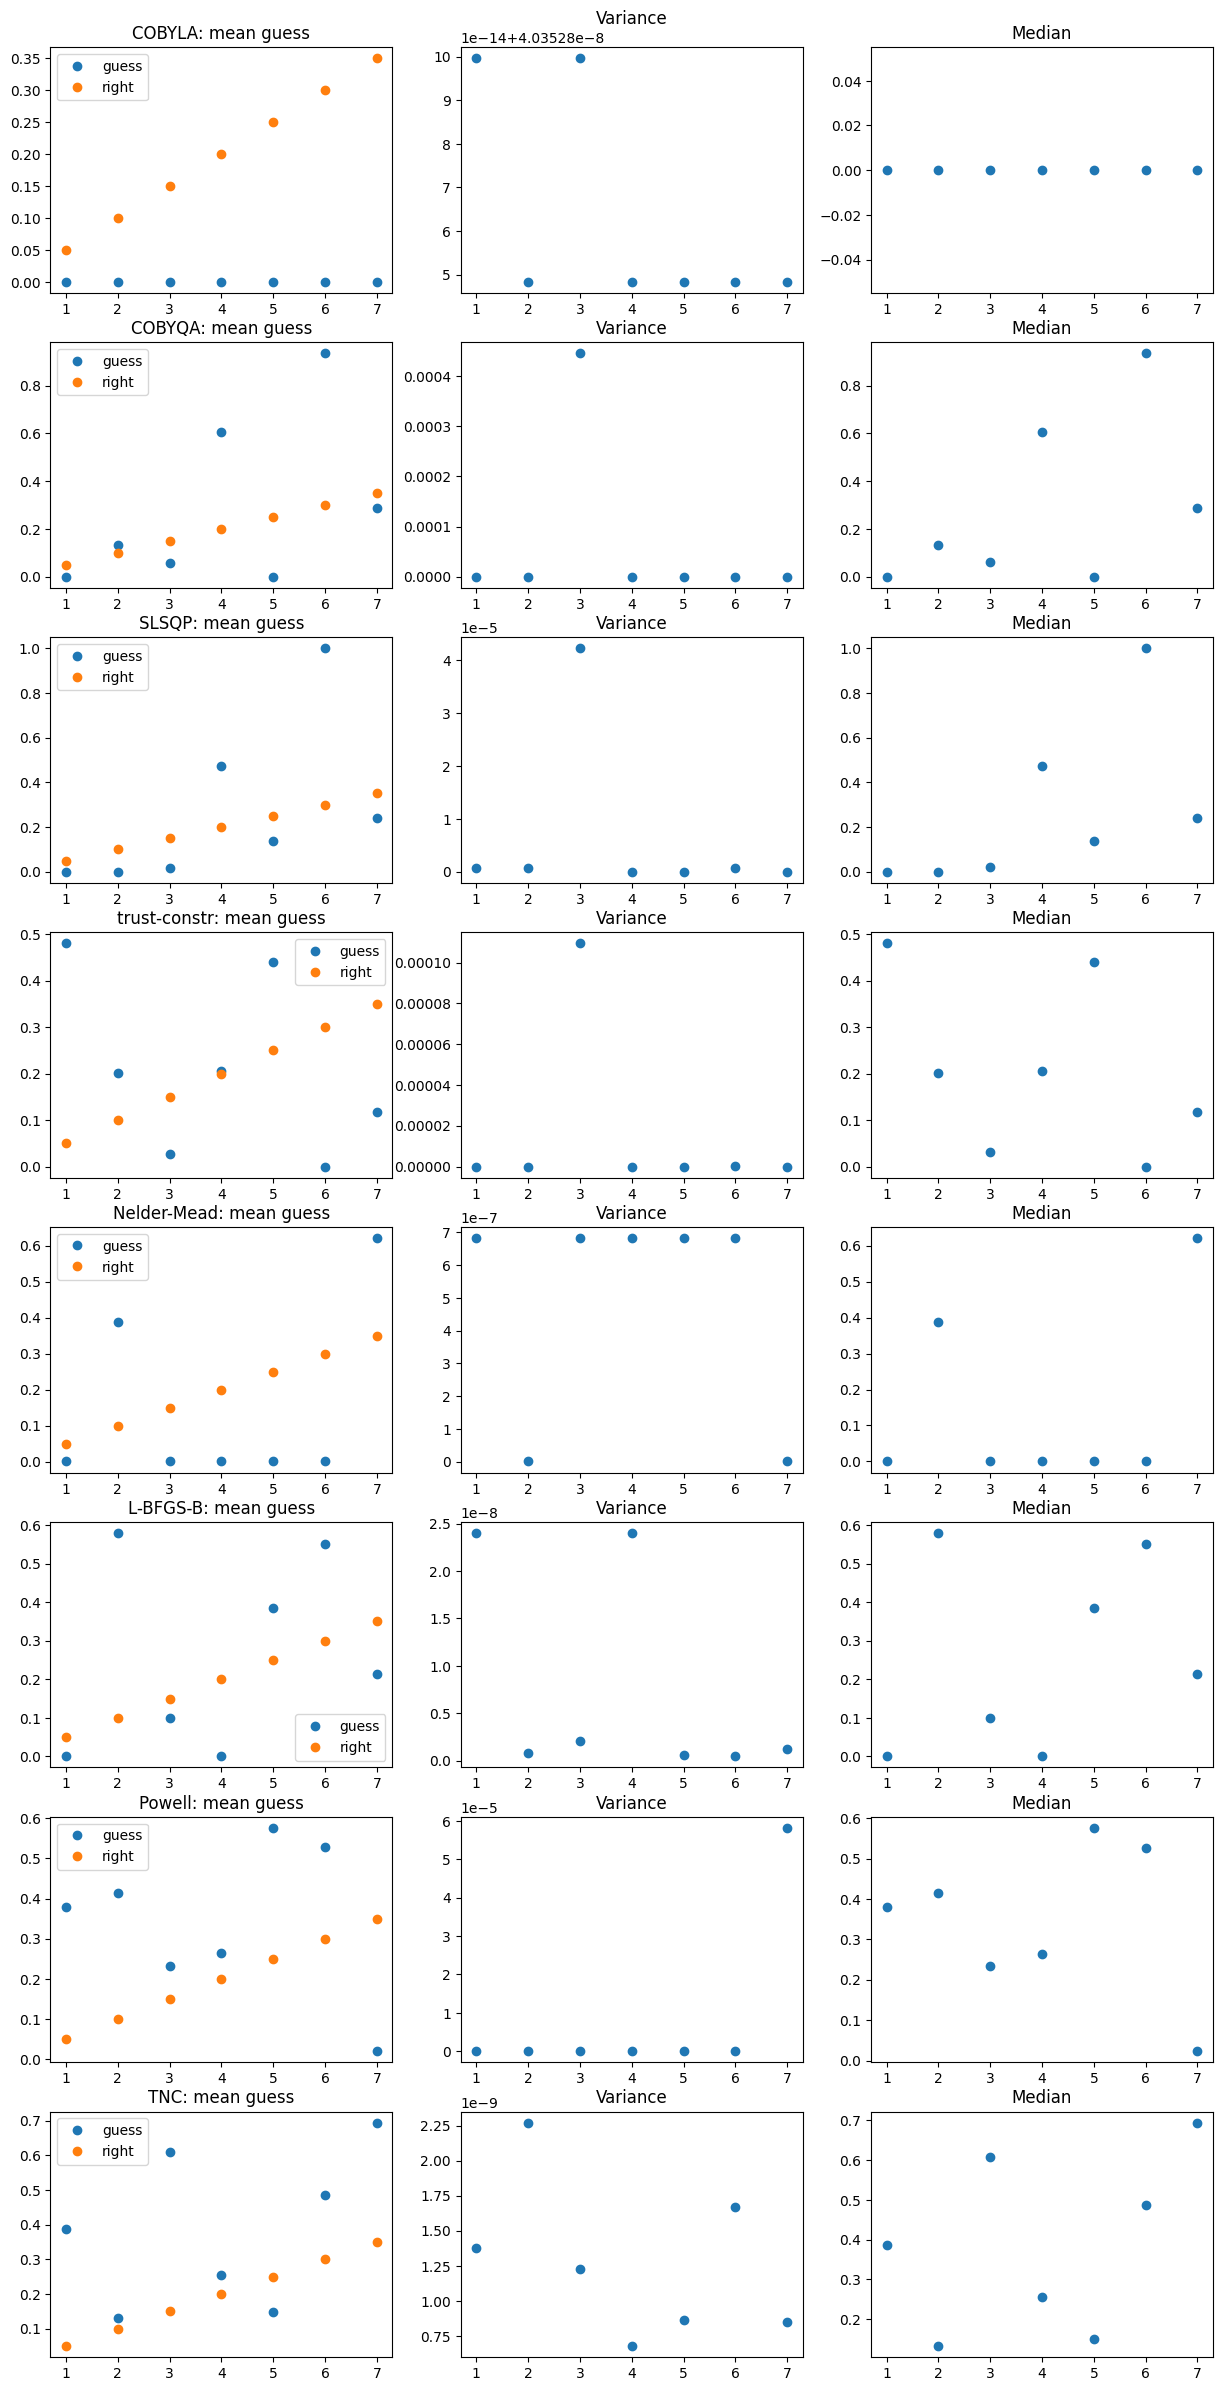

In [423]:
visualize_absolute(res3_1_1, save=True, idea=3, mean_func_num=1, single_func_num=1, version=2)

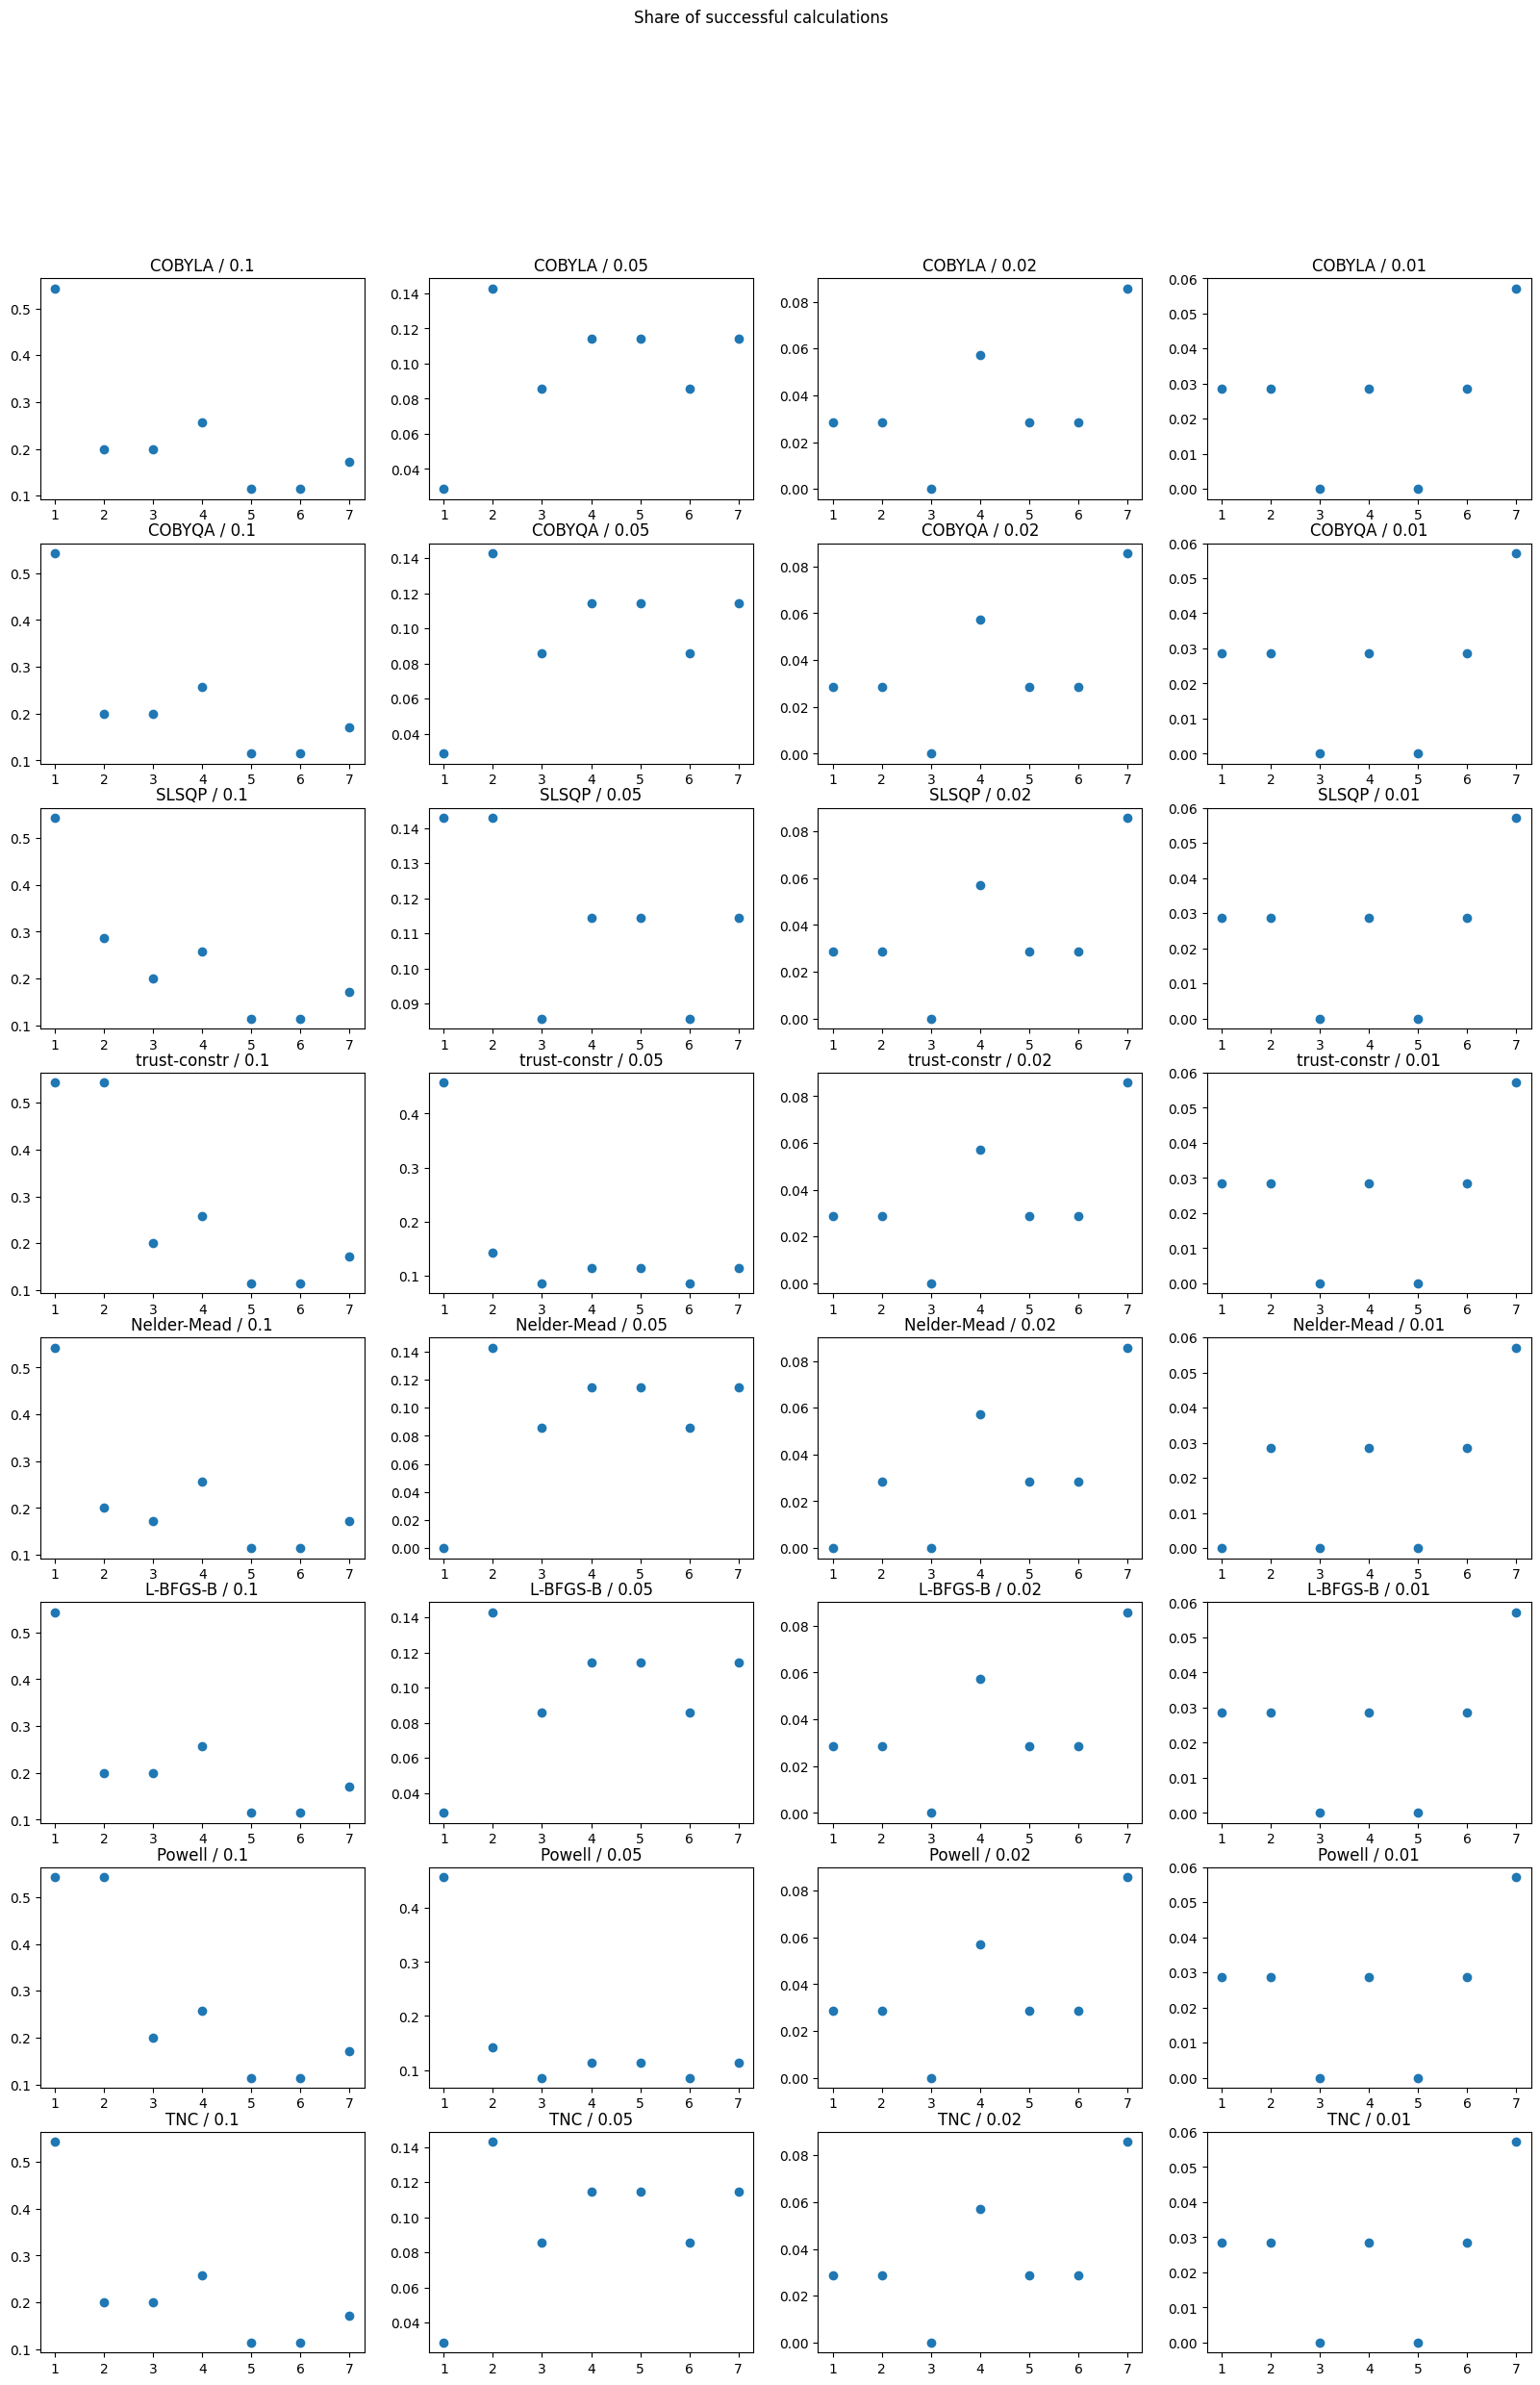

In [424]:
visualize_error(res3_1_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=3, mean_func_num=1, single_func_num=1, version=2)

## Выводы?

Да почему ж ты работаешь хуже, чем предыдущие методы...

# Идея 4: Пытаемся перекинуть идею 3 на векторы

Сделаем не скалярное распределение на основе вектора весов, а векторное w_1 / (w_1 + w_2)

Внизу все нули заменяем на 1 (или на что-то другое??? - на подумать) - медианой мб

Смотря на пороговое значение 0.05, i2 d2 f1 на TNC/Powell дает сравнительно высокий результат, но все почему-то валятся на 0.35

i1 d5 f1: кроме Nedler-Mead фактически не обнуляются доли правильных попыток

Проверим на 4к-векторах, потому что не совсем понятно пока, как интерпретировать взвешивание кол-во соседей из A в ячейке, индекс которой и значит это самое кол-во.

## Распределение для одного экземпляра

### d4.1 4k

In [44]:
def single_distr4_1(treeseq, reference, sample, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    # 0 - для A, 1 - для B
    vector = np.zeros((2, 4*k_ref))
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        # nearest_pop = [tree.population(nd) for nd in nearest]        
        neighbours = nearest.size
        refA_neighbours = nearest[nearest < 2 * k_ref].size
        refB_neighbours = nearest[(2 * k_ref <= nearest) & (nearest < 4 * k_ref)].size
        vector[0, neighbours-1] += tree.span * refA_neighbours
        vector[1, neighbours-1] += tree.span * refB_neighbours
    vector /= subts.sequence_length
    return vector

## Распределение для популяции

### f4.1

In [47]:
def mean_distribution4_1(treeseq, reference, samples, single_func, k_ref):
    vec = np.zeros((2, 4*k_ref))
    for el in samples:
        vec += single_func(treeseq, reference, el, k_ref)
    vec /= samples.size
    num = vec[0]
    denom = np.sum(vec, axis=0)
    # чтобы не разделить на 0
    denom[denom == 0] = 1
    return num / denom

## Тестируем

In [48]:
res4_1_1 = get_accuracy_test_results(
    mean_d_func=mean_distribution4_1,
    single_func=single_distr4_1,
    algorithms=methods,
    k_ref=k_reference,
    k_learn=k_learning,
    k_val=k_validation,
    num_m=m,
    seq_len=sequence_len,
    rec_rate=recomb_rate,
    repl=replicates
)

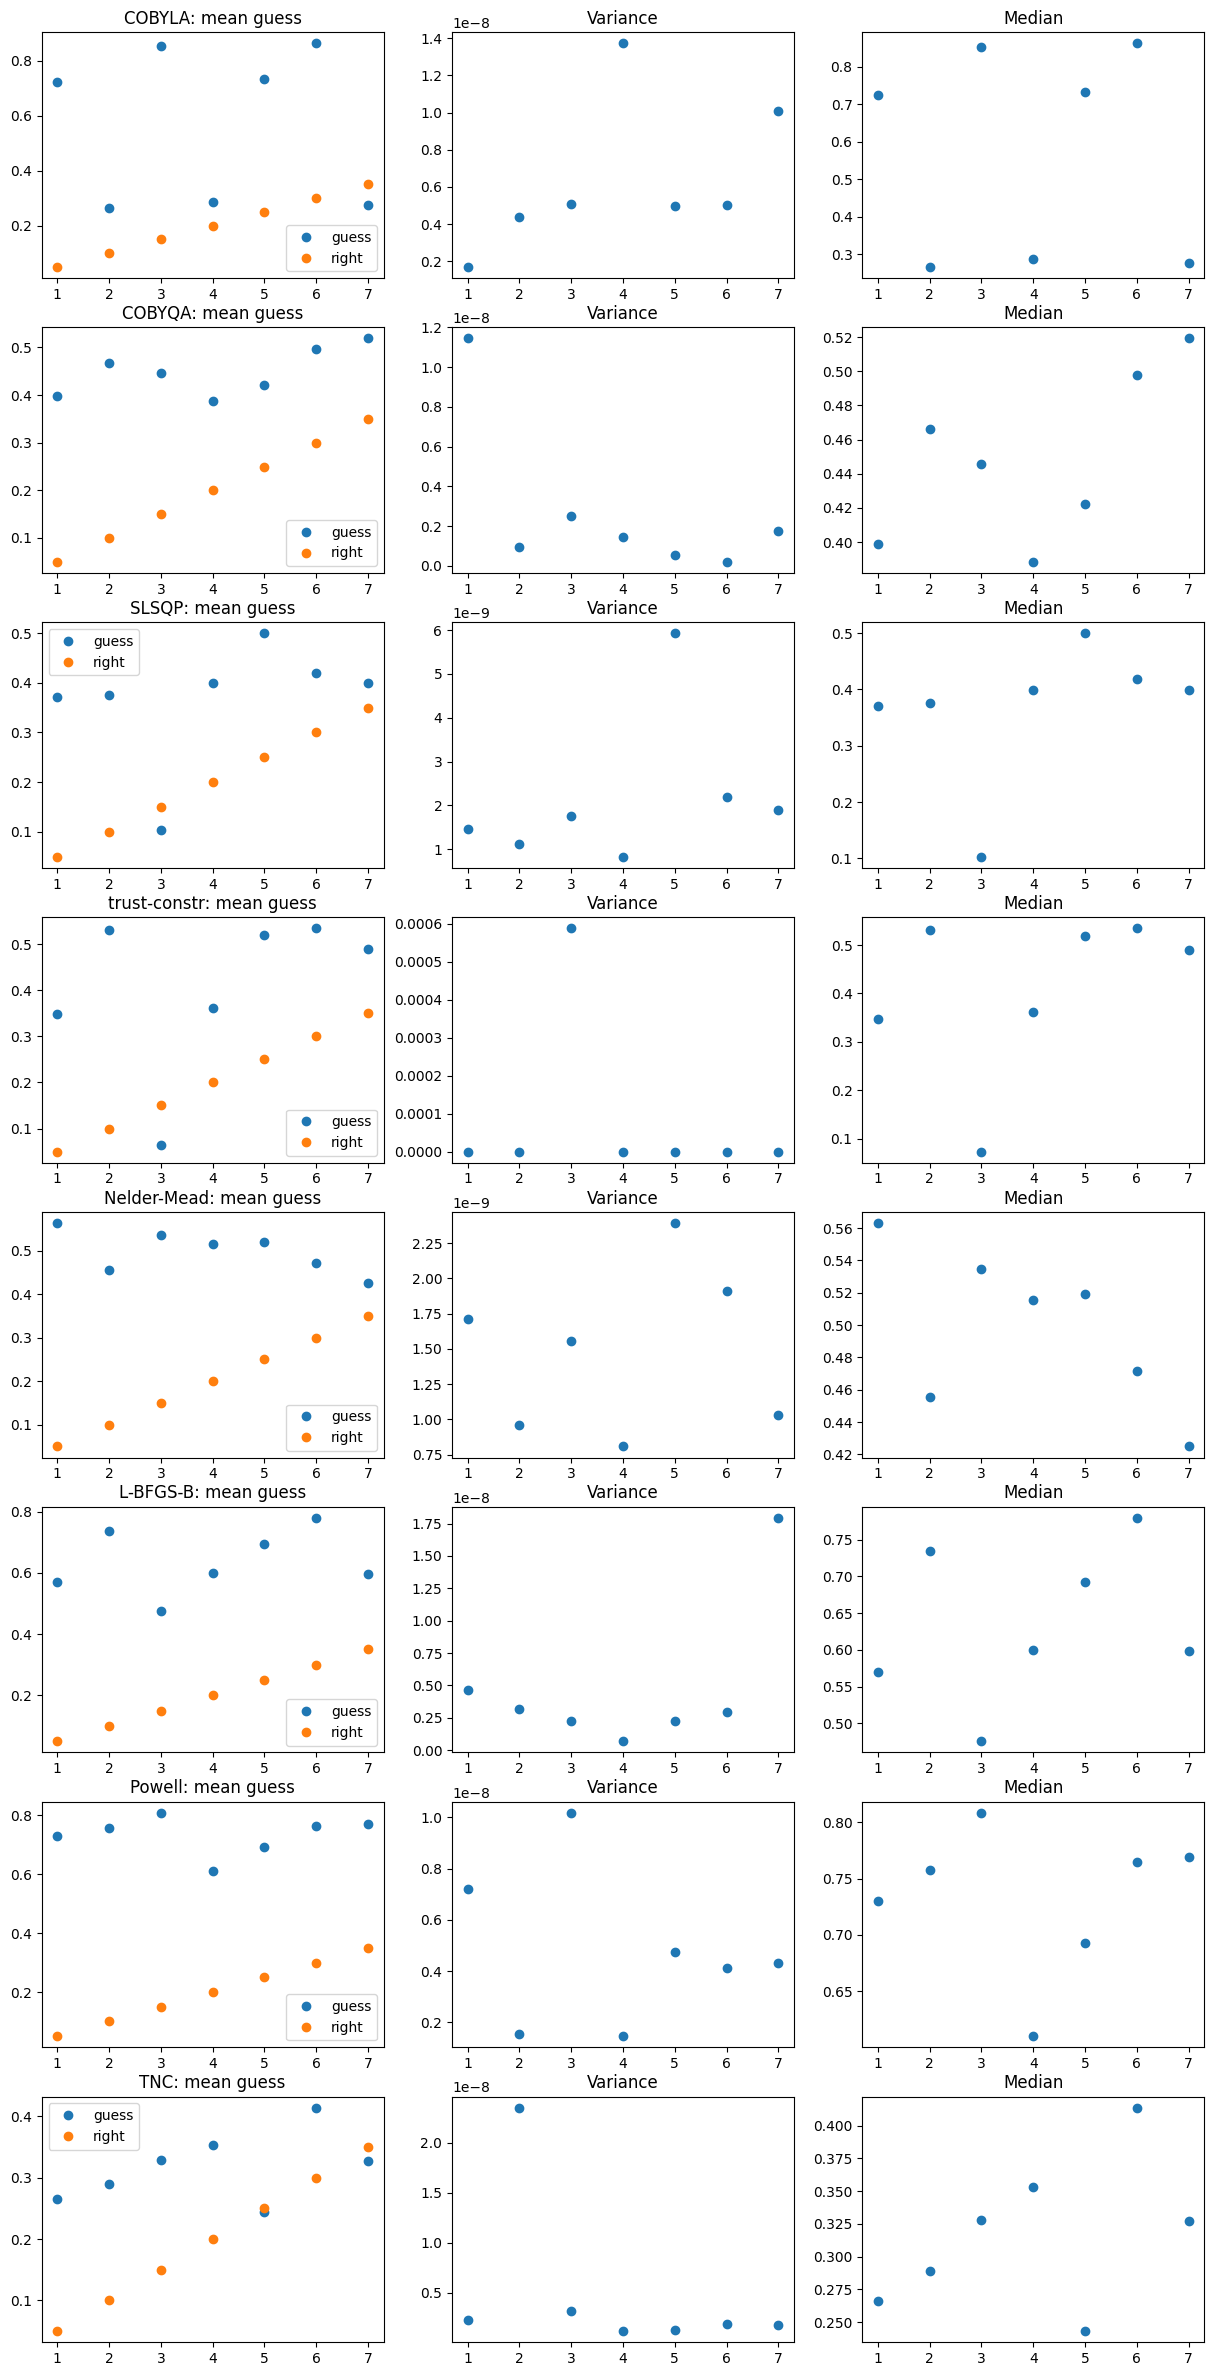

In [50]:
visualize_absolute(res4_1_1,
                   methods,
                   save=True, 
                   idea=4,
                   mean_func_num=1,
                   single_func_num=1,
                   version=2)

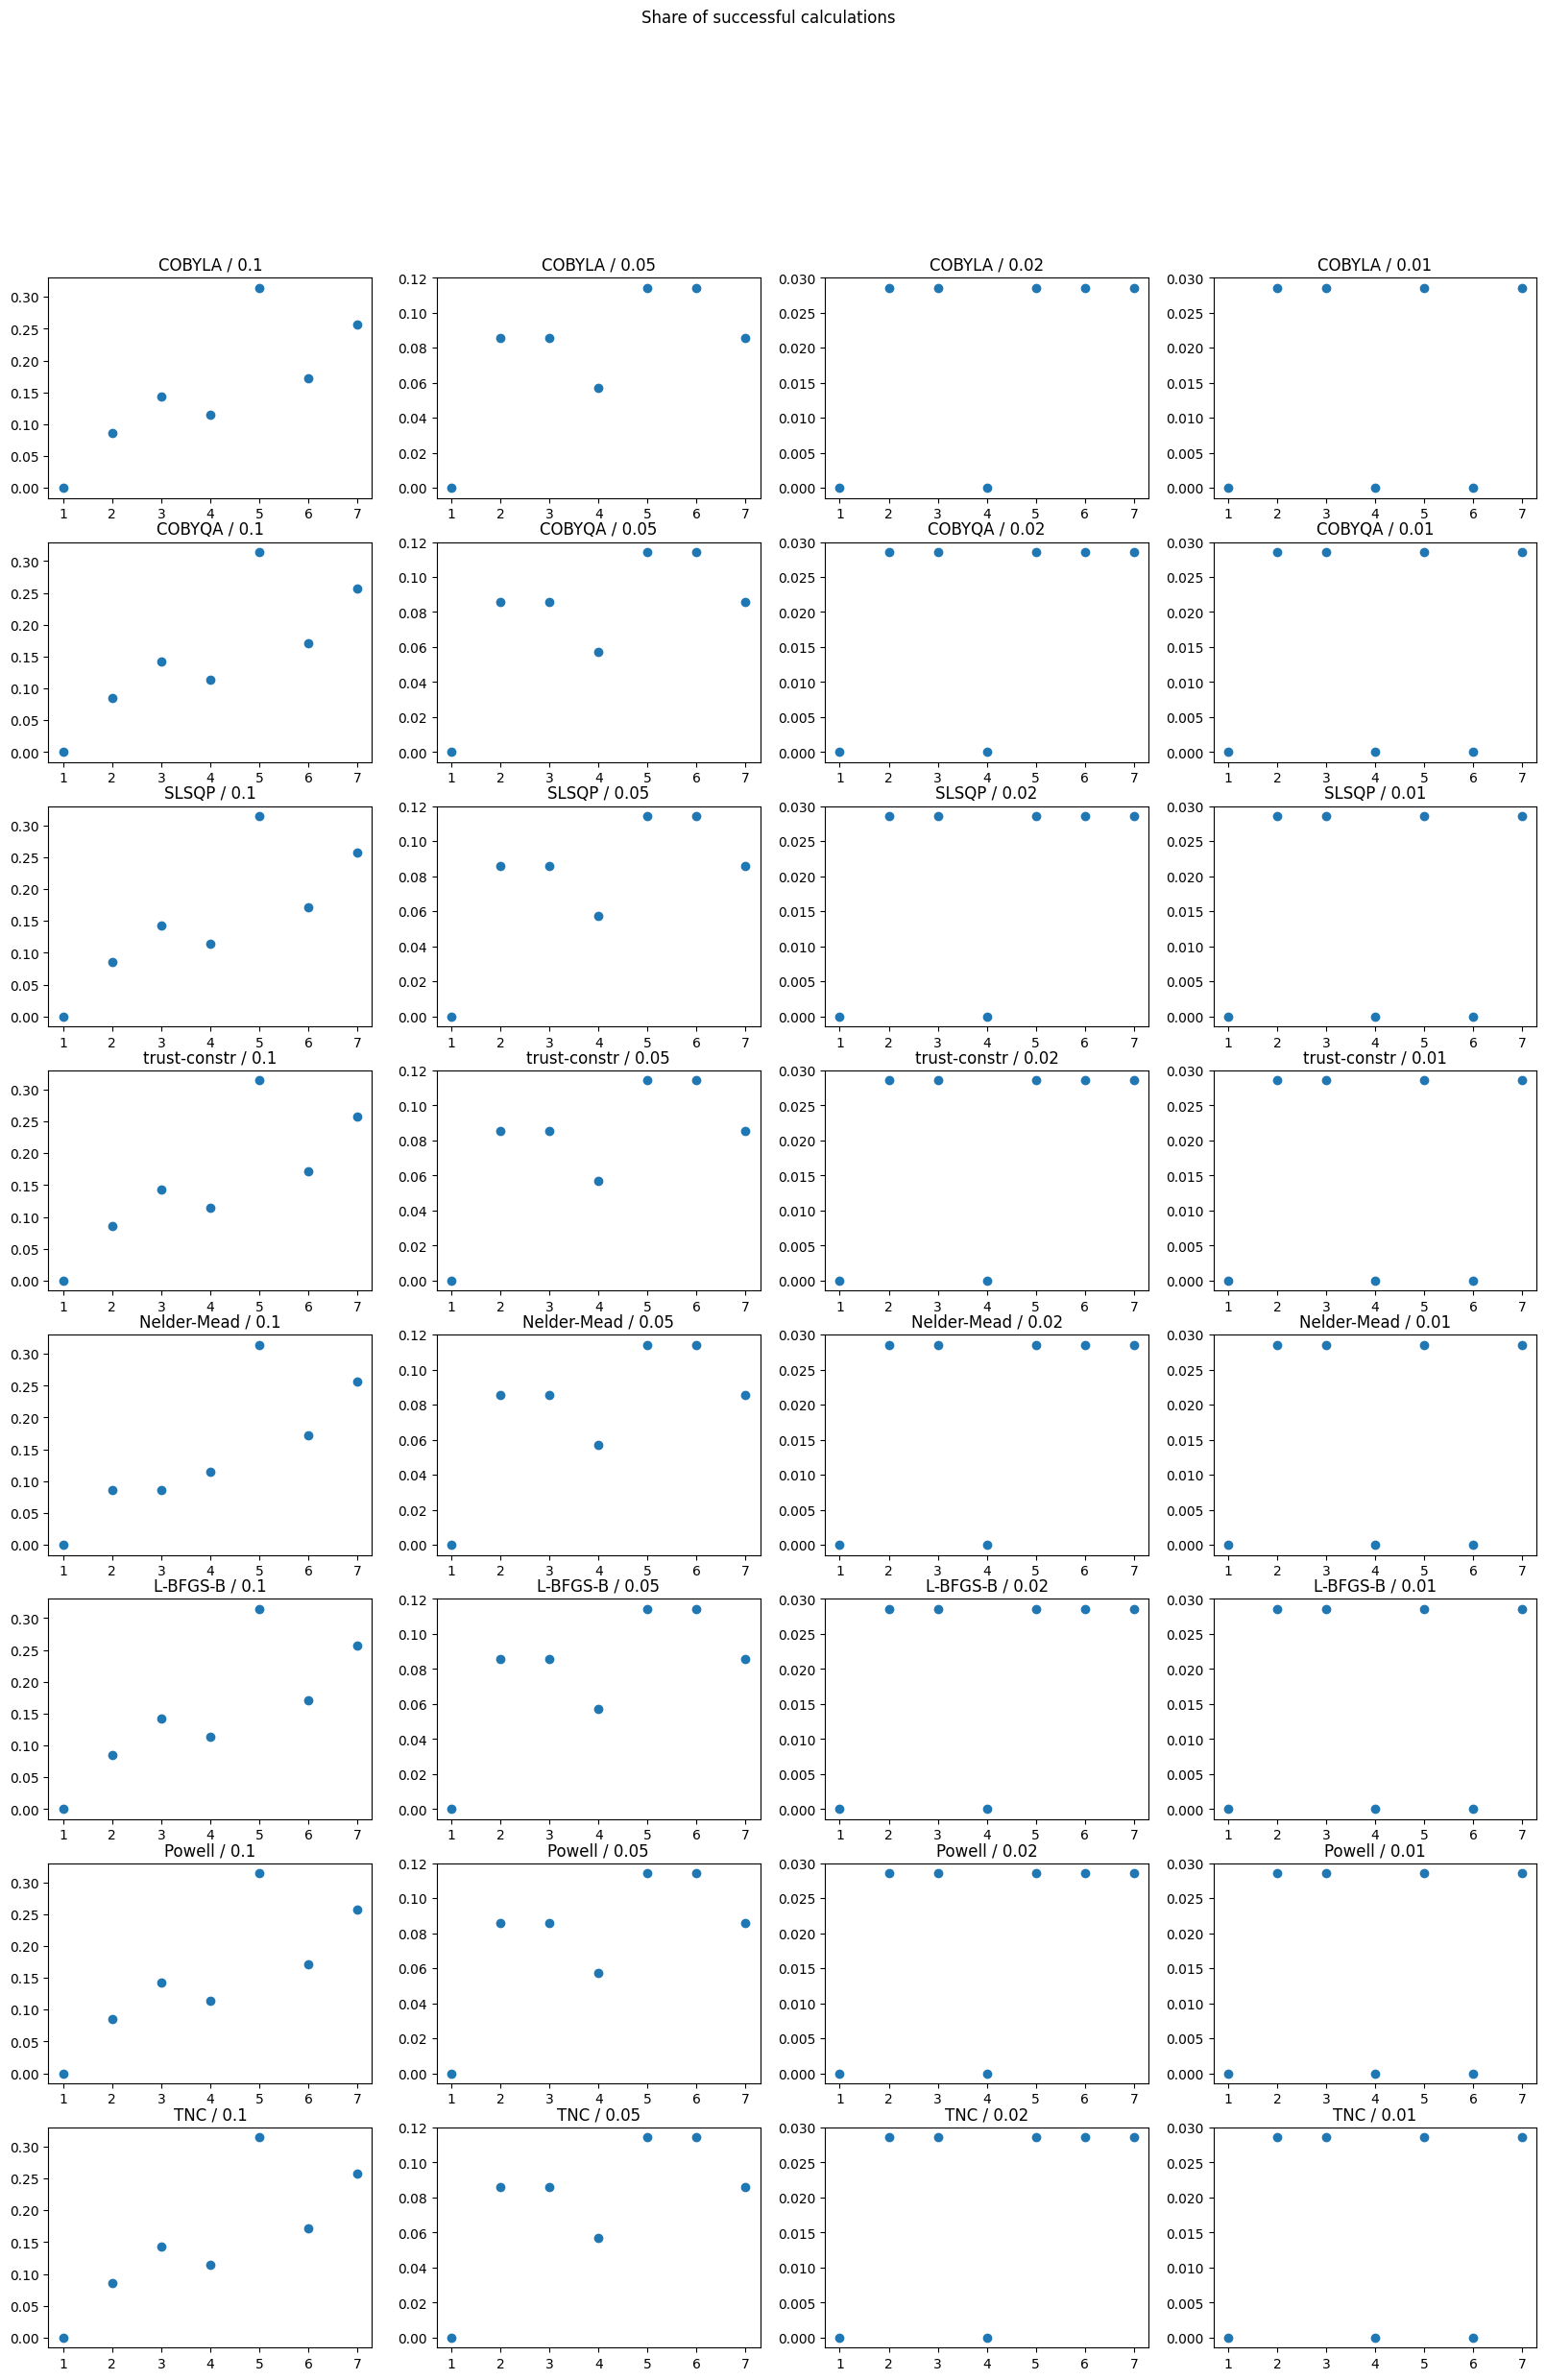

In [53]:
visualize_error(res4_1_1,
                np.array([0.1, 0.05, 0.02, 0.01]),
                save=True,
                idea=4,
                mean_func_num=1,
                single_func_num=1,
                version=2)

# На подумать

1) Мы не юзаем нигде референсы B

2) record_full_arg (bool) – If True, record all intermediate nodes arising from common ancestor and recombination events in the output tree sequence. This will result in unary nodes (i.e., nodes in marginal trees that have only one child). Defaults to False. See the Ancestral recombination graph section for examples.

3) Надо что-то посмотреть с мат ожиданием числа соседей и учитывать это при нормировании аккуратнее.

4) "при условии, что на ветке $i$ референсов" - нормировать тогда надо не по всему $L$, а по сумме длин деревьев, на которых $i$ референсов из $A$ 

5) Может быть как-то обучаться на референсах тоже?

6) Когда 0 референсных особей (идея 2) это грустно, портит ли это стату?

7) А какие еще данные топологического анализа нам могут помочь, помимо длины ветки?

https://tskit.dev/tskit/docs/stable/topological-analysis.html#sec-combinatorics

https://tskit.dev/tutorials/analysing_trees.html#sec-analysing-trees

https://tskit.dev/tutorials/counting_topologies.html#sec-counting-topologies

https://tskit.dev/tutorials/popgen.html

Взвешивать по "расстоянию" в ребрах?

### [Not implemented] d1.4. Нормируем по числу соседей из A для данной ветки